In [290]:
import pandas as pd
import numpy as np
import json
import datetime as dt
from datetime import datetime, date, time,timedelta
import pandas as pd
from csv import DictWriter
import urllib
import re,datetime
import os
import time
from os import walk
import re
import gc
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)


#############
#INPUTS
#############

delta = 15

backtest_start_date = '1-1-2021'
backtest_end_date = '31-1-2023'

index = "BANKNIFTY"
index_file_path = "D:\Correlation Backtest Data 2016-23\Correlation 6-16 to 1-23 data\Input Files\Index\BANKNIFTY.csv"

stfolder = "D:/Correlation Backtest Data 2016-23/Correlation 6-16 to 1-23 data/Input Files/Stocks"
    
wgt_lot_path = "D:\Correlation Backtest Data 2016-23\Correlation 6-16 to 1-23 data\Input Files\Others\BN Mcap & includeok - Copy - Copy.csv"

direc = r"D:/Correlation Backtest Data 2016-23/Correlation 6-16 to 1-23 data/Working Files/Entry & Exit @ Expiry - 1/Delta_" + str(delta)

output_path = r"D:/Correlation Backtest Data 2016-23/Correlation 6-16 to 1-23 data/Output Files/Entry & Exit @ Expiry - 1/Delta_" + str(delta)

index_lotsize = 1

initial_equity = 100000


#########################
#Creating Stock List
#########################

# filename = next(walk(stfolder), (None, None, []))[2]  # [] if no file
# stock_list_path = []
# for i in filename:
#     temp = stfolder +"/"+ i
#     stock_list_path.append(temp)

    
# stock_list = []
# for i in stock_list_path:
#     stock_list.append(i.replace(".csv","").replace(stfolder + "/",""))
# print(stock_list)

stock_list_df = pd.read_csv(wgt_lot_path, parse_dates = ['date'], dayfirst = True)
stock_list_df = stock_list_df[(stock_list_df['date'] >= pd.to_datetime(backtest_start_date, format = '%d-%m-%Y', dayfirst = True)) & (stock_list_df['includeok'] == 1)]
stock_list = stock_list_df['Security Symbol'].unique().tolist()
print(stock_list)

######################################    
#Creating weight and lot dictionary
######################################

"""wgtlot_df = pd.read_csv(wgt_lot_path)
wgtlot_dict = wgtlot_df.set_index('Symbol').T.to_dict('list')
print(wgtlot_dict)
symbols = list(wgtlot_dict.keys())"""

### Now adding Columns for weights below

######################################

lookback_period = 15
std_dev = 2

####################
#EXPIRY DATES
####################
symbols = stock_list.copy()
symbols.append(index)

exp_file_path = "D:\Correlation Backtest Data 2016-23\Correlation 6-16 to 1-23 data\Input Files\Others\MonthlyExpiry.csv"

exp_df = pd.read_csv(exp_file_path,parse_dates = ["curr_exp_date","Date"],dayfirst =True,usecols = ["curr_exp_date","Date"])
#exp_df.rename({'curr_date': 'Date'}, axis=1, inplace=True)

['AXISBANK', 'BANDHANBNK', 'BANKBARODA', 'FEDERALBNK', 'HDFCBANK', 'ICICIBANK', 'IDFCFIRSTB', 'INDUSINDBK', 'KOTAKBANK', 'PNB', 'RBLBANK', 'SBIN', 'AUBANK']


### Separating Current Month, Next Month and Far Month data

In [291]:
idx = pd.read_csv(index_file_path,parse_dates = ["Date"],dayfirst = True)
idx = idx[idx['Date'] >= pd.to_datetime(backtest_start_date, format = '%d-%m-%Y', dayfirst = True)]


df1 = idx[idx['Ticker'].str.endswith('-I')]
df2 = idx[idx['Ticker'].str.endswith('-II')]
df3 = idx[idx['Ticker'].str.endswith('-III')]



index_file_path = direc + "/BANKNIFTY.csv"

df1.to_csv(index_file_path)
df2.to_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-II"))
df3.to_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-III"))

print(idx.shape[0])
print(df1.shape[0]+df2.shape[0]+df3.shape[0])
    
for i in stock_list:
    df = pd.read_csv(stfolder + '/' + i + ".csv",parse_dates = ["Date"],dayfirst = True)
    df = df[df['Date'] >= pd.to_datetime(backtest_start_date, format = '%d-%m-%Y', dayfirst = True)]

    df1 = df[df['Ticker'].str.endswith('-I')]
    df2 = df[df['Ticker'].str.endswith('-II')]
    df3 = df[df['Ticker'].str.endswith('-III')]
    
    path = direc + '/' + i + ".csv"
    
    df1.to_csv(path)
    df2.to_csv(path.replace(i,i+"-II"))
    df3.to_csv(path.replace(i,i+"-III"))
    
    print(df.shape[0])
    print(df1.shape[0]+df2.shape[0]+df3.shape[0])

stfolder = direc
print(index_file_path)

160508
160508
37214
37214
29467
29467
32183
32183
33275
33275
43792
43792
52864
52864
29913
29913
33518
33518
34909
34909
25174
25174
27533
27533
53943
53943
18506
18506
D:/Correlation Backtest Data 2016-23/Correlation 6-16 to 1-23 data/Working Files/Entry & Exit @ Expiry - 1/Delta_15/BANKNIFTY.csv


In [292]:
idx = pd.read_csv(index_file_path,usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close", "IV", 'Delta', f'Delta_{delta}_Strike'],parse_dates = ["Date"])

idx = pd.merge(idx, exp_df, on = 'Date', how = 'left')

idx_ce = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "CE")].add_suffix("_CE")
idx_pe = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "PE")].add_suffix("_PE")


final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])

final = final.T.drop_duplicates().T  #Drop Duplicates Columns

final = final.add_prefix(index +"_")
final = final.sort_values(by=index +"_"+'Date_CE')

final.to_csv(output_path+"/check-1data.csv")

d1 = dt.datetime.strptime('2021-09-28','%Y-%m-%d')
d2 = dt.datetime.strptime('2021-11-04','%Y-%m-%d')
d3 = dt.datetime.strptime('2021-12-21','%Y-%m-%d')

final.drop(final[(final['BANKNIFTY_Date_CE'] == d1) | (final['BANKNIFTY_Date_CE'] == d2) | (final['BANKNIFTY_Date_CE'] == d3)].index, inplace = True)
final.to_csv(output_path+"/check-11111data.csv")
display(final)

for i in stock_list:
    print(i)
    df1 = pd.read_csv(stfolder+ '/' + i + ".csv",parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"])

    df1 = pd.merge(df1, exp_df, on = 'Date', how = 'left')
    
    
    df_ce = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "CE")].add_suffix("_CE")
    df_pe = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "PE")].add_suffix("_PE")
    print(df1.shape[0], df_ce.shape[0], df_pe.shape[0])
    temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
    temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    
    
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Date_CE')
    
final = final.T.drop_duplicates().T
final = final.drop_duplicates()
curr_final_df = final.copy()
u = curr_final_df.select_dtypes(exclude=['datetime'])
curr_final_df[u.columns] = u.fillna(0)

curr_final_df.to_csv(output_path+"/check-2data.csv")

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600,0.237336,0.1477,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.5,29100,0.276237,-0.152445
1,2021-01-04,BANKNIFTY33500CE-I,157.0,33500,0.25063,0.154373,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.0,29100,0.288968,-0.152024
2,2021-01-05,BANKNIFTY34000CE-I,155.85,34000,0.250926,0.153868,31722.25,2021-01-28,BANKNIFTY29600PE-I,185.65,29600,0.28913,-0.150481
3,2021-01-06,BANKNIFTY34000CE-I,148.0,34000,0.246358,0.152071,31797.9004,2021-01-28,BANKNIFTY29600PE-I,169.0,29600,0.292087,-0.140673
4,2021-01-07,BANKNIFTY34000CE-I,160.0,34000,0.245461,0.164704,31956.0,2021-01-28,BANKNIFTY30000PE-I,156.15,30000,0.267529,-0.144177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,2023-01-24,BANKNIFTY43100CE-I,25.0,43100,0.150981,0.144675,42733.4492,2023-01-25,BANKNIFTY42400PE-I,34.0,42400,0.162587,-0.173391
511,2023-01-25,BANKNIFTY49500CE-I,0.2,49500,5.0,0.0,41647.6484,2023-01-25,BANKNIFTY41600PE-I,0.05,41600,5.0,0.0
512,2023-01-27,BANKNIFTY43000CE-I,168.8,43000,0.205979,0.148207,40345.3008,NaT,BANKNIFTY38000PE-I,245.85,38000,0.24857,-0.16476
513,2023-01-30,BANKNIFTY43100CE-I,178.85,43100,0.226674,0.150722,40387.4492,NaT,BANKNIFTY38000PE-I,248.65,38000,0.266328,-0.164742


AXISBANK
25960 513 513
BANDHANBNK
21178 513 513
BANKBARODA
24429 513 513
FEDERALBNK
26442 513 513
HDFCBANK
28717 513 513
ICICIBANK
34493 682 682
IDFCFIRSTB
20514 513 513
INDUSINDBK
23932 513 513
KOTAKBANK
25041 514 514
PNB
16892 514 514
RBLBANK
20412 514 514
SBIN
34559 514 514
AUBANK
15509 474 474


In [293]:
idx = pd.read_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-II"),usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"],parse_dates = ["Date"])


idx = pd.merge(idx, exp_df, on = 'Date', how = 'left')


idx_ce = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "CE")].add_suffix("_CE")
idx_pe = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "PE")].add_suffix("_PE")


final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])

final = final.T.drop_duplicates().T  #Drop Duplicates Columns

final = final.add_prefix(index +"_")
final = final.sort_values(by=index +"_"+'Date_CE')
final.to_csv(output_path+"/check-3data.csv")

for i in stock_list:
    print(i)
    path  = stfolder+ '/' + i + ".csv"
    df1 = pd.read_csv(path.replace(i,i+"-II"),parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"])
    df1 = pd.merge(df1, exp_df, on = 'Date', how = 'left')

    
    df_ce = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "CE")].add_suffix("_CE")
    df_pe = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "PE")].add_suffix("_PE")
    
    
    temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
    temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Date_CE')



    

final = final.T.drop_duplicates().T
final = final.drop_duplicates()
next_final_df = final.copy()

next_final_df.to_csv(output_path+"/check-4.0data.csv")

u = next_final_df.select_dtypes(exclude=['datetime'])
next_final_df[u.columns] = u.fillna(0)

next_final_df.to_csv(output_path+"/check-4data.csv")

AXISBANK
BANDHANBNK
BANKBARODA
FEDERALBNK
HDFCBANK
ICICIBANK
IDFCFIRSTB
INDUSINDBK
KOTAKBANK
PNB
RBLBANK
SBIN
AUBANK


In [294]:
replacedf = curr_final_df[curr_final_df[index + "_Date_CE"] == curr_final_df[index + "_curr_exp_date_CE"]]
restdf = curr_final_df[~(curr_final_df[index + "_Date_CE"] == curr_final_df[index + "_curr_exp_date_CE"])]

nextdf = next_final_df[next_final_df[index + "_Date_CE"] == next_final_df[index + "_curr_exp_date_CE"]]



for i in symbols:
    if nextdf.shape[0] == replacedf.shape[0]:
        replacedf[i + "_IV_CE"] = nextdf[i + "_IV_CE"]
        replacedf[i + "_IV_PE"] = nextdf[i + "_IV_PE"]
        replacedf[i + '_Strike_CE'] = nextdf[i + '_Strike_CE']
        if delta!=50:
            replacedf[i + '_Strike_PE'] = nextdf[i + '_Strike_PE']
        else:
            replacedf[i + '_Strike_PE'] = nextdf[i + '_Strike_CE']
        replacedf[i + '_Delta_CE'] = nextdf[i + '_Delta_CE']
        replacedf[i + '_Delta_PE'] = nextdf[i + '_Delta_PE']
        
        print("EXCHANGE DONE")
    else:
        print("Entries Missing Error")
        break

final = restdf.append(replacedf).sort_values(by=[index+"_Date_CE"]).reset_index().drop(columns = ["index"])


EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE
EXCHANGE DONE


In [295]:
final.to_csv(output_path+"\Part-1data.csv")
data = pd.read_csv(output_path+"\Part-1data.csv",parse_dates = [index + "_Date_CE"],dayfirst = True)


In [296]:
#Adding Avg IV Columns
data[index + "_Avg IV"] = (data[index + "_IV_CE"] + data[index + "_IV_PE"])/2
curr_final_df[index + "_Avg IV"] = data[index + "_Avg IV"]

data[index + "_Avg Delta"] = (data[index + "_Delta_CE"] + (- data[index + "_Delta_PE"]))/2
curr_final_df[index + "_Avg Delta"] = data[index + "_Avg Delta"]

for i in stock_list:
    data[i + "_Avg IV"] = (data[i + "_IV_CE"] + data[i + "_IV_PE"])/2
    curr_final_df[i + "_Avg IV"] = data[i + "_Avg IV"]
    
    data[i + "_Avg Delta"] = (data[i + "_Delta_CE"] + (- data[i + "_Delta_PE"]))/2
    curr_final_df[i + "_Avg Delta"] = data[i + "_Avg Delta"]
    
    
data = curr_final_df.copy()

# Adding Weights Columns

In [297]:
weight = pd.read_csv(wgt_lot_path,parse_dates = ["date"],dayfirst = True,usecols = ["Security Symbol","Weightage","date","includeok","Lotsize"])

In [298]:
grp = weight.groupby("Security Symbol")
data[index + "_OG_Weight"] = 100
for i in stock_list:
    d1 = grp.get_group(i)
    d1[i + "_OG_Weight"] = d1["Weightage"]
    d1[index+ "_Date_CE"] = d1["date"]
    data = pd.merge(data,d1[[index+ "_Date_CE",i + "_OG_Weight"]],on= index+ "_Date_CE", how='left')

if data.isnull().sum().sum() != 0:
    print(data.isnull().sum().sum())
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")



7344
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR


### Adding Final Weight Columns

In [299]:
filter_col = [col for col in data if col.endswith('Weight')]
filter_col.remove(index + "_OG_Weight")

data["actual_wgt_sum"] = data[filter_col].sum(axis=1)

for i in stock_list:
    data[i + "_Final_Weight"] = data[i + "_OG_Weight"]/data["actual_wgt_sum"]
data[index + "_Final_Weight"] = 1

In [300]:
u = data.select_dtypes(exclude=['datetime'])
data[u.columns] = u.fillna(0)



In [301]:
data['index_iv'] = data[index +'_Avg IV']*100
data['stock_iv']  = 0


data['index_delta'] = data[index +'_Avg Delta']*100
data['stock_delta']  = 0


for i in stock_list:
    data['stock_iv'] += data[i + '_Avg IV']*data[i + "_Final_Weight"] 
    
    data['stock_delta'] += data[i + '_Avg Delta']*data[i + "_Final_Weight"]
    
data['implied_correl'] = (data['index_iv']/data['stock_iv'])

print(data.isnull().sum().sum())

325


In [302]:
data['avg'] = data['implied_correl'].rolling(lookback_period).mean()
df = data.copy()

df.to_csv(output_path+'/impliedratio.csv')

In [303]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * std_dev # Calculate top band
    bollinger_down = sma - std * std_dev # Calculate bottom band
    return bollinger_up, bollinger_down

df['bollinger_up'], df['bollinger_down'] = get_bollinger_bands(df['implied_correl'], lookback_period)

df['sma'] = get_sma(df['implied_correl'], lookback_period)
df['long_avg'] = df['implied_correl'].mean()


#print(df['bollinger_up'])
#print(df['bollinger_down'])
#print(df['long_avg'])
#print(df['sma'])

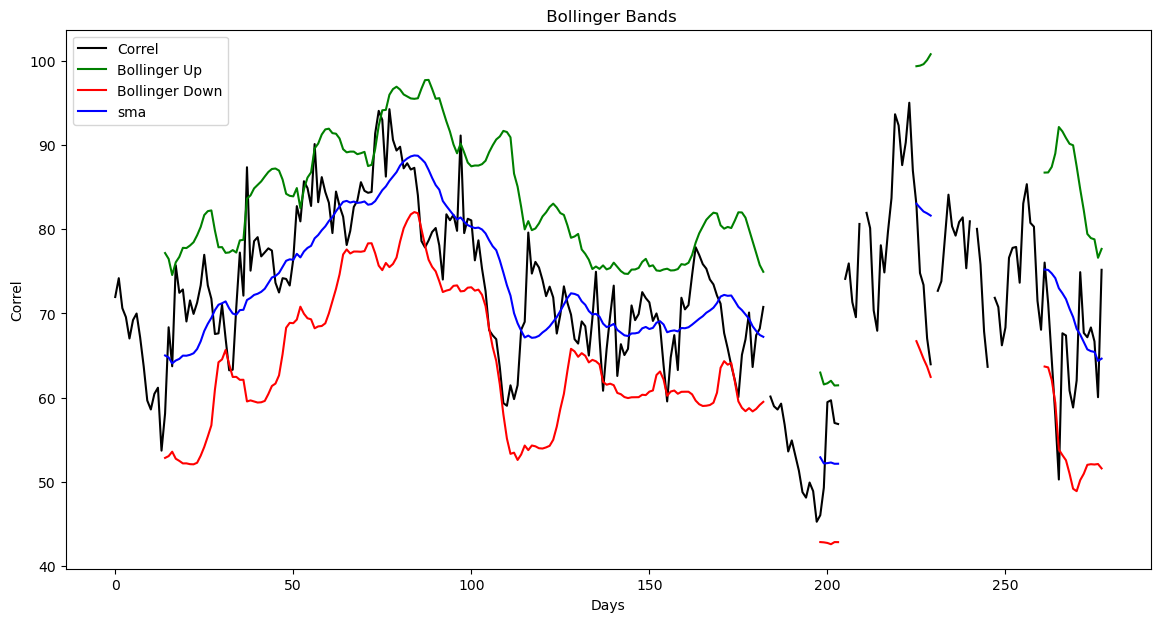

In [304]:
import matplotlib.pyplot as plt

df.head()

fig = plt.figure(figsize=(14,7))
plt.title(' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Correl')
plt.plot(df['implied_correl'], label='Correl', c = 'black')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='g')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='r')
plt.plot(df['sma'], label='sma', c='b')

plt.legend()
plt.show()

In [305]:
df.to_csv(output_path+"\series.csv")

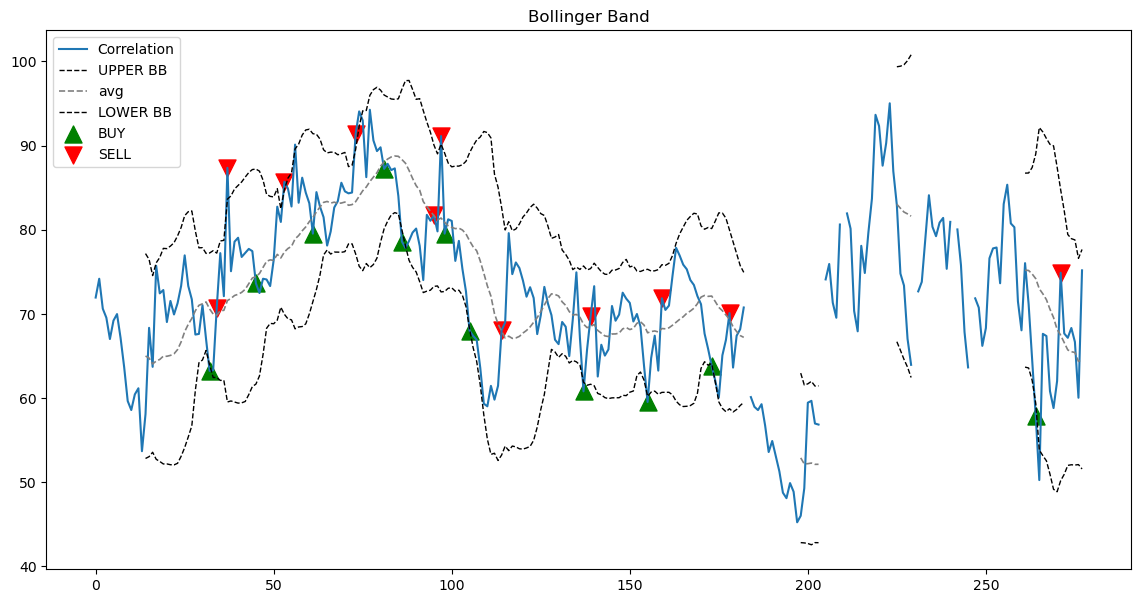

In [306]:
def implement_bb_strategy(data, lower_bb, upper_bb, avg):
    entry_ratio = []
    exit_ratio = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if(i==0):
            if data[i] < lower_bb[i]:
                if signal != 1:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(0)
            elif data[i] > upper_bb[i]:
                if signal != -1:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = -1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(0)
            else:
                entry_ratio.append(np.nan)
                exit_ratio.append(np.nan)
                bb_signal.append(0)
        else:
            if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
                if signal != 1:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            elif data[i-1] > avg[i-1] and data[i] < avg[i]:
                if signal != 0:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 0
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])                
            
            elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
                if signal != -1:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = -1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            elif data[i-1] < avg[i-1] and data[i] > avg[i]:
                if signal != 0:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = 0
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            else:
                entry_ratio.append(np.nan)
                exit_ratio.append(np.nan)
                bb_signal.append(bb_signal[i-1])

    return entry_ratio, exit_ratio, bb_signal

df['entry_ratio'], df['exit_ratio'], df['bb_signal'] = implement_bb_strategy(df['implied_correl'], df['bollinger_down'], df['bollinger_up'], df['avg'])

fig = plt.figure(figsize=(14,7))


df['implied_correl'].plot(label = 'Correlation', alpha = 1)
df['bollinger_up'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df['avg'].plot(label = 'avg', linestyle = '--', linewidth = 1.2, color = 'grey')
df['bollinger_down'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df.index, df['entry_ratio'], marker = '^', color = 'green', label = 'BUY', s = 150)
plt.scatter(df.index, df['exit_ratio'], marker = 'v', color = 'red', label = 'SELL', s = 150)
plt.title('Bollinger Band')
plt.legend(loc = 'upper left')
plt.show()


In [307]:
df1 = df.copy()

In [308]:
df1['dispersion_entry'] = False #(df1['bb_signal'] == -1) & (df1['exit_ratio'] > 0)  & (df1['entry_ratio'].isna() == True)
df1['dispersion_exit'] = False #(df1['bb_signal'] == 0) & (df1['entry_ratio'] > 0) & (df1['entry_ratio'].isna() == False)

df1['correlation_entry'] = np.nan
df1['correlation_exit'] = np.nan
df1['bb_signal'] = np.nan

#df1['correlation_entry'] = (df1['bb_signal'] == 1) & (df1['entry_ratio'] > 0)  & (df1['exit_ratio'].isna() == True)
#df1['correlation_exit'] = (df1['bb_signal'] == 0)  & (df1['exit_ratio'] > 0)  & (df1['exit_ratio'].isna() == False):

#df1['bb_signal'] = df1.apply(lambda x: 0 if x['BANKNIFTY_Date_CE']==x['BANKNIFTY_curr_exp_date_CE'] else 1, axis=1)



for i in range(len(df1)):
    if(i==0):
        df1.loc[i,'correlation_entry'] = True
        df1.loc[i,'correlation_exit'] = False
    elif (df1.loc[i-1, 'BANKNIFTY_Date_CE'] == df1.loc[i-1, 'BANKNIFTY_curr_exp_date_CE']):  
        df1.loc[i-2,'correlation_entry'] = True
        df1.loc[i-2,'correlation_exit'] = True
#     elif (df1.loc[i,'BANKNIFTY_Date_CE'] == df1.loc[i,'BANKNIFTY_curr_exp_date_CE']):
#         df1.loc[i,'correlation_entry'] = False
#         df1.loc[i,'correlation_exit'] = True
    else:
        df1.loc[i,'correlation_entry'] = False
        df1.loc[i,'correlation_exit'] = False
        
df1['bb_signal'] = df1.apply(lambda x: 0 if x['correlation_entry']==True else 1, axis=1)
        
    

In [309]:
df2 = df1.copy()

for idi, row in df2.iterrows():
    if ((df2.loc[idi,'bb_signal'] == 0)):
        
        date = df2.loc[idi, 'BANKNIFTY_Date_CE']
        loldf = next_final_df[next_final_df['BANKNIFTY_Date_CE'] == date]
        if len(loldf) != 0:
            df2.loc[idi, index+'_Nextmonth_Strike_CE'] = loldf[index+'_Strike_CE'].iat[0]
            df2.loc[idi, index+'_Nextmonth_Strike_PE'] = loldf[index+'_Strike_PE'].iat[0]
            df2.loc[idi, index+'_Nextmonth_OPT_Close_CE'] = loldf[index+'_OPT_Close_CE'].iat[0]
            df2.loc[idi, index+'_Nextmonth_OPT_Close_PE'] = loldf[index+'_OPT_Close_PE'].iat[0]
            for i in stock_list:    
                if i == "AUBANK":
                    display(date)
                    display(loldf)
                df2.loc[idi, i+'_Nextmonth_Strike_CE'] = loldf[i+'_Strike_CE'].iat[0]
                df2.loc[idi, i+'_Nextmonth_Strike_PE'] = loldf[i+'_Strike_PE'].iat[0]
                df2.loc[idi, i+'_Nextmonth_OPT_Close_CE'] = loldf[i+'_OPT_Close_CE'].iat[0]
                df2.loc[idi, i+'_Nextmonth_OPT_Close_PE'] = loldf[i+'_OPT_Close_PE'].iat[0]
                    
                    
display(df2)                  

df2.to_csv(output_path + '//' + 'with entry exit signals_all data.csv')

Timestamp('2021-01-01 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
0,2021-01-01,BANKNIFTY34200CE-II,333.0,34200,0.247884,0.205908,31225.8496,2021-01-28,BANKNIFTY28000PE-II,230.1,28000,0.279593,-0.129285,2021-01-01,AXISBANK730CE-II,9.0,730.0,0.395808,0.18434,623.8,2021-01-28,AXISBANK550PE-II,10.5,550.0,0.411839,-0.179782,NaT,0,0.0,0,0.0,0.0,0.0,NaT,0,0.0,0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0,2021-01-01,SBIN320CE-II,5.75,320.0,0.413775,0.235999,279.4,2021-01-28,SBIN240PE-II,3.8,240.0,0.426698,-0.147446,NaT,0,0.0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0


Timestamp('2021-01-27 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
17,2021-01-27,BANKNIFTY33500CE-II,197.85,33500,0.315681,0.147856,30284.5508,2021-01-28,BANKNIFTY27500PE-II,247.85,27500,0.360007,-0.148903,2021-01-27,AXISBANK740CE-II,7.0,740.0,0.506749,0.157473,632.1,2021-01-28,AXISBANK550PE-II,7.35,550.0,0.516458,-0.145359,2021-01-27,BANDHANBNK380CE-II,4.3,380,0.693603,0.151714,303.7,2021-01-28,BANDHANBNK250PE-II,5.0,250,0.729222,-0.142425,2021-01-27,BANKBARODA90CE-II,1.5,90.0,0.714669,0.198012,74.05,2021-01-28,BANKBARODA60PE-II,1.05,60.0,...,0.0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0,2021-01-27,RBLBANK280CE-II,3.3,280.0,0.755658,0.149932,218.65,2021-01-28,RBLBANK180PE-II,4.15,180.0,0.767798,-0.152417,2021-01-27,SBIN330CE-II,3.3,330.0,0.567937,0.153851,275.65,2021-01-28,SBIN240PE-II,3.9,240.0,0.552754,-0.160341,NaT,0,0.0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0


Timestamp('2021-02-24 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
37,2021-02-24,BANKNIFTY39400CE-II,180.0,39400,0.240626,0.145763,36452.3008,2021-02-25,BANKNIFTY32900PE-II,315.9,32900,0.382018,-0.148313,2021-02-24,AXISBANK840CE-II,6.0,840.0,0.366797,0.155163,749.4,2021-02-25,AXISBANK650PE-II,8.25,650.0,0.514388,-0.139606,2021-02-24,BANDHANBNK400CE-II,4.5,400,0.582585,0.165612,335.15,2021-02-25,BANDHANBNK290PE-II,5.75,290,0.611653,-0.17123,2021-02-24,BANKBARODA110CE-II,1.25,110.0,0.683122,0.153365,88.35,2021-02-25,BANKBARODA74PE-II,1.8,74.0,...,1.3,50.0,0.804782,0.254737,41.8,2021-02-25,PNB38PE-II,1.55,38.0,0.702815,-0.273853,2021-02-24,RBLBANK300CE-II,3.0,300.0,0.605149,0.148588,246.55,2021-02-25,RBLBANK200PE-II,3.7,200.0,0.741773,-0.130285,2021-02-24,SBIN470CE-II,4.0,470.0,0.462976,0.153382,406.25,2021-02-25,SBIN355PE-II,4.85,355.0,0.510745,-0.149858,NaT,0,0.0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0


Timestamp('2021-03-24 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
56,2021-03-24,BANKNIFTY37700CE-II,271.2,37700,0.349126,0.150369,33293.25,2021-03-25,BANKNIFTY30000PE-II,255.1,30000,0.334229,-0.13727,2021-03-24,AXISBANK820CE-II,6.3,820.0,0.407405,0.143679,706.4,2021-03-25,AXISBANK630PE-II,8.15,630.0,0.40978,-0.160343,2021-03-24,BANDHANBNK430CE-II,4.9,430,0.540042,0.164369,357.45,2021-03-25,BANDHANBNK310PE-II,5.25,310,0.514379,-0.160134,2021-03-24,BANKBARODA92CE-II,1.05,92.0,0.671153,0.147249,71.8,2021-03-25,BANKBARODA60PE-II,0.7,60.0,...,0.5,47.0,0.639768,0.14308,37.0,2021-03-25,PNB32PE-II,0.55,32.0,0.523019,-0.159385,2021-03-24,RBLBANK265CE-II,3.15,265.0,0.590205,0.161768,215.9,2021-03-25,RBLBANK185PE-II,2.5,185.0,0.498271,-0.136157,2021-03-24,SBIN420CE-II,3.3,420.0,0.421252,0.143241,359.85,2021-03-25,SBIN320PE-II,3.9,320.0,0.406976,-0.15346,NaT,0,0.0,0.0,0.0,0.0,0.0,NaT,0,0.0,0.0,0.0,0.0


Timestamp('2021-04-28 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
77,2021-04-28,BANKNIFTY37000CE-II,212.05,37000,0.294118,0.151488,33722.8008,2021-04-29,BANKNIFTY30500PE-II,295.7,30500,0.378547,-0.150861,2021-04-28,AXISBANK800CE-II,5.7,800.0,0.384469,0.150273,708.15,2021-04-29,AXISBANK630PE-II,7.4,630.0,0.44414,-0.1517,2021-04-28,BANDHANBNK380CE-II,4.0,380,0.496268,0.172692,328.5,2021-04-29,BANDHANBNK290PE-II,4.05,290,0.491223,-0.158901,2021-04-28,BANKBARODA80CE-II,0.85,80.0,0.546775,0.164444,67.75,2021-04-29,BANKBARODA60PE-II,0.95,60.0,...,0.4,43.0,0.572228,0.145112,35.65,2021-04-29,PNB31PE-II,0.45,31.0,0.53328,-0.151006,2021-04-28,RBLBANK230CE-II,2.7,230.0,0.579247,0.171454,193.65,2021-04-29,RBLBANK165PE-II,3.0,165.0,0.627446,-0.154592,2021-04-28,SBIN415CE-II,3.5,415.0,0.4316,0.158975,363.4,2021-04-29,SBIN320PE-II,3.7,320.0,0.464892,-0.142949,2021-04-28,AUBANK600CE-II,23.2,600.0,0.509906,0.418726,574.4,2021-04-29,AUBANK500PE-II,8.75,500.0,0.568957,-0.165842


Timestamp('2021-05-26 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
96,2021-05-26,BANKNIFTY37500CE-II,223.45,37500,0.263505,0.168257,34684.1992,2021-05-27,BANKNIFTY31900PE-II,254.95,31900,0.316644,-0.152109,2021-05-26,AXISBANK820CE-II,6.0,820.0,0.358443,0.160418,735.1,2021-05-27,AXISBANK670PE-II,6.1,670.0,0.35275,-0.153147,2021-05-26,BANDHANBNK340CE-II,3.5,340,0.507312,0.167665,292.1,2021-05-27,BANDHANBNK260PE-II,3.2,260,0.450425,-0.155659,2021-05-26,BANKBARODA102.5CE-II,1.25,102.5,0.747581,0.15452,80.6,2021-05-27,BANKBARODA67.5PE-II,1.2,67.5,...,1.4,45.0,0.744042,0.298377,39.25,2021-05-27,PNB35PE-II,0.9,35.0,0.603299,-0.216758,2021-05-26,RBLBANK250CE-II,2.4,250.0,0.571399,0.148706,207.85,2021-05-27,RBLBANK180PE-II,2.8,180.0,0.556283,-0.153398,2021-05-26,SBIN475CE-II,3.6,475.0,0.430131,0.146858,413.55,2021-05-27,SBIN370PE-II,4.5,370.0,0.436587,-0.158939,2021-05-26,AUBANK550CE-II,5.8,550.0,0.465961,0.17951,481.525,2021-05-27,AUBANK430PE-II,5.625,430.0,0.452962,-0.163018


Timestamp('2021-06-23 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
116,2021-06-23,BANKNIFTY37200CE-II,171.3,37200,0.205321,0.152077,34574.0,2021-06-24,BANKNIFTY32400PE-II,180.0,32400,0.216889,-0.144387,2021-06-23,AXISBANK810CE-II,5.75,810.0,0.298734,0.16462,732.35,2021-06-24,AXISBANK670PE-II,5.05,670.0,0.291276,-0.141572,2021-06-23,BANDHANBNK390CE-II,3.6,390,0.449347,0.155786,333.15,2021-06-24,BANDHANBNK300PE-II,4.2,300,0.40134,-0.174969,2021-06-23,BANKBARODA100CE-II,0.85,100.0,0.512719,0.135766,82.3,2021-06-24,BANKBARODA70PE-II,0.95,70.0,...,0.6,53.0,0.62614,0.151421,42.25,2021-06-24,PNB37PE-II,0.6,37.0,0.485759,-0.163702,2021-06-23,RBLBANK250CE-II,2.25,250.0,0.496202,0.144385,208.35,2021-06-24,RBLBANK180PE-II,1.95,180.0,0.447659,-0.125771,2021-06-23,SBIN480CE-II,3.6,480.0,0.378385,0.147602,418.85,2021-06-24,SBIN380PE-II,3.7,380.0,0.335994,-0.153164,2021-06-23,AUBANK600CE-II,7.0,600.0,0.502534,0.174041,508.575,2021-06-24,AUBANK450PE-II,6.5,450.0,0.443826,-0.162574


Timestamp('2021-07-28 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
140,2021-07-28,BANKNIFTY36600CE-II,134.5,36600,0.181336,0.150371,34532.8984,2021-07-29,BANKNIFTY32500PE-II,167.75,32500,0.223985,-0.145434,2021-07-28,AXISBANK790CE-II,4.75,790.0,0.289512,0.158894,722.9,2021-07-29,AXISBANK660PE-II,4.85,660.0,0.324082,-0.13865,2021-07-28,BANDHANBNK340CE-II,2.9,340,0.446324,0.157081,296.05,2021-07-29,BANDHANBNK260PE-II,3.85,260,0.514169,-0.159485,2021-07-28,BANKBARODA92.5CE-II,0.9,92.5,0.539842,0.15509,78.05,2021-07-29,BANKBARODA70PE-II,1.0,70.0,...,0.45,45.0,0.518327,0.162039,38.4,2021-07-29,PNB34PE-II,0.45,34.0,0.474858,-0.157068,2021-07-28,RBLBANK230CE-II,1.9,230.0,0.526042,0.139088,192.95,2021-07-29,RBLBANK170PE-II,2.4,170.0,0.497794,-0.158232,2021-07-28,SBIN470CE-II,2.95,470.0,0.318599,0.15404,425.5,2021-07-29,SBIN390PE-II,3.2,390.0,0.327477,-0.15063,2021-07-28,AUBANK650CE-II,8.0,650.0,0.412784,0.216617,587.075,2021-07-29,AUBANK500PE-II,4.2,500.0,0.488162,-0.102914


Timestamp('2021-08-25 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
159,2021-08-25,BANKNIFTY37700CE-II,139.45,37700,0.160298,0.152927,35586.25,2021-08-26,BANKNIFTY33500PE-II,181.7,33500,0.20596,-0.148356,2021-08-25,AXISBANK810CE-II,3.7,810.0,0.242,0.134752,739.05,2021-08-26,AXISBANK680PE-II,3.8,680.0,0.253596,-0.125435,2021-08-25,BANDHANBNK310CE-II,2.65,310,0.440192,0.148793,264.6,2021-08-26,BANDHANBNK230PE-II,3.6,230,0.494914,-0.155759,2021-08-25,BANKBARODA87.5CE-II,0.65,87.5,0.410628,0.139353,75.1,2021-08-26,BANKBARODA67.5PE-II,0.85,67.5,...,0.35,42.0,0.402627,0.153965,36.45,2021-08-26,PNB32PE-II,0.4,32.0,0.437045,-0.145908,2021-08-25,RBLBANK190CE-II,1.5,190.0,0.437255,0.140604,161.55,2021-08-26,RBLBANK140PE-II,2.0,140.0,0.485034,-0.146999,2021-08-25,SBIN465CE-II,2.85,465.0,0.304961,0.145037,416.25,2021-08-26,SBIN380PE-II,2.6,380.0,0.286298,-0.132625,2021-08-25,AUBANK790CE-II,5.0,790.0,0.399947,0.125159,675.15,2021-08-26,AUBANK600PE-II,9.5,600.0,0.450168,-0.173285


Timestamp('2021-09-29 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
183,2021-09-29,BANKNIFTY40700CE-II,201.95,40700,0.241752,0.154973,37743.0,2021-09-30,BANKNIFTY35400PE-II,215.5,35400,0.245042,-0.153705,2021-09-29,AXISBANK900CE-II,6.45,900.0,0.426803,0.141365,782.15,2021-09-30,AXISBANK700PE-II,6.6,700.0,0.398583,-0.14008,2021-09-29,BANDHANBNK350CE-II,3.8,350,0.646987,0.152468,284.4,2021-09-30,BANDHANBNK250PE-II,4.2,250,0.537047,-0.169945,2021-09-29,BANKBARODA102.5CE-II,1.0,102.5,0.669227,0.138356,81.7,2021-09-30,BANKBARODA70PE-II,1.1,70.0,...,0.7,52.0,0.843062,0.157137,39.65,2021-09-30,PNB34PE-II,0.5,34.0,0.567489,-0.143068,2021-09-29,RBLBANK240CE-II,2.35,240.0,0.706706,0.134995,188.15,2021-09-30,RBLBANK160PE-II,2.1,160.0,0.564075,-0.130395,2021-09-29,SBIN540CE-II,4.65,540.0,0.49809,0.148169,460.0,2021-09-30,SBIN410PE-II,4.1,410.0,0.415874,-0.141212,2021-09-29,AUBANK700CE-II,8.5,700.0,0.626502,0.168459,579.45,2021-09-30,AUBANK500PE-II,8.25,500.0,0.576797,-0.155396


Timestamp('2021-10-27 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
208,2021-10-27,BANKNIFTY43600CE-II,170.25,43600,0.199685,0.147108,40874.3516,2021-10-28,BANKNIFTY38300PE-II,220.35,38300,0.242496,-0.148058,2021-10-27,AXISBANK910CE-II,7.7,910.0,0.459399,0.153417,787.5,2021-10-28,AXISBANK690PE-II,8.05,690.0,0.477519,-0.140174,2021-10-27,BANDHANBNK370CE-II,4.9,370,0.725398,0.166525,296.15,2021-10-28,BANDHANBNK250PE-II,4.8,250,0.661788,-0.153038,2021-10-27,BANKBARODA117CE-II,3.45,117.0,0.708623,0.295017,102.6,2021-10-28,BANKBARODA85PE-II,2.0,85.0,...,1.6,54.0,0.777841,0.282674,46.3,2021-10-28,PNB39PE-II,0.6,39.0,0.616508,-0.136133,2021-10-27,RBLBANK255CE-II,4.2,255.0,0.730357,0.19424,208.25,2021-10-28,RBLBANK180PE-II,2.9,180.0,0.567899,-0.154735,2021-10-27,SBIN605CE-II,7.05,605.0,0.532088,0.178861,519.15,2021-10-28,SBIN455PE-II,5.9,455.0,0.494714,-0.148053,2021-10-27,AUBANK750CE-II,10.025,750.0,0.596242,0.185638,633.875,2021-10-28,AUBANK550PE-II,9.75,550.0,0.579371,-0.16456


Timestamp('2021-11-24 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
276,2021-11-24,BANKNIFTY39800CE-II,154.6,39800,0.169911,0.152355,37441.9492,2021-11-25,BANKNIFTY35300PE-II,182.2,35300,0.199485,-0.146559,2021-11-24,AXISBANK760CE-II,4.25,760.0,0.282264,0.142174,685.15,2021-11-25,AXISBANK630PE-II,5.75,630.0,0.30067,-0.161297,2021-11-24,BANDHANBNK350CE-II,2.95,350,0.36756,0.164262,309.1,2021-11-25,BANDHANBNK270PE-II,2.65,270,0.412669,-0.125629,2021-11-24,BANKBARODA108CE-II,1.0,108.0,0.425191,0.161345,93.35,2021-11-25,BANKBARODA85PE-II,1.25,85.0,...,0.45,47.0,0.439,0.162354,40.45,2021-11-25,PNB36PE-II,0.35,36.0,0.374742,-0.137425,2021-11-24,RBLBANK230CE-II,2.25,230.0,0.41965,0.169471,200.05,2021-11-25,RBLBANK180PE-II,2.25,180.0,0.386062,-0.165191,2021-11-24,SBIN550CE-II,3.2,550.0,0.29675,0.141835,493.15,2021-11-25,SBIN455PE-II,3.75,455.0,0.282845,-0.156895,2021-11-24,AUBANK700CE-II,4.0,700.0,0.375361,0.120215,602.4,2021-11-25,AUBANK550PE-II,6.0,550.0,0.336633,-0.168207


Timestamp('2021-12-29 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
373,2021-12-29,BANKNIFTY37400CE-II,145.95,37400,0.200715,0.146493,35045.3984,2021-12-30,BANKNIFTY32700PE-II,206.85,32700,0.260282,-0.150162,2021-12-29,AXISBANK740CE-II,4.35,740.0,0.310025,0.149122,670.5,2021-12-30,AXISBANK610PE-II,4.55,610.0,0.333552,-0.136578,2021-12-29,BANDHANBNK295CE-II,2.5,295,0.506415,0.144964,250.1,2021-12-30,BANDHANBNK210PE-II,3.4,210,0.634513,-0.137972,2021-12-29,BANKBARODA93CE-II,0.8,93.0,0.448375,0.157654,80.95,2021-12-30,BANKBARODA70PE-II,0.7,70.0,...,0.35,43.0,0.457559,0.149329,37.15,2021-12-30,PNB33PE-II,0.4,33.0,0.452657,-0.152895,2021-12-29,RBLBANK180CE-II,2.5,180.0,0.732999,0.171513,144.3,2021-12-30,RBLBANK110PE-II,3.3,110.0,1.027131,-0.13639,2021-12-29,SBIN505CE-II,2.95,505.0,0.32515,0.143765,454.4,2021-12-30,SBIN410PE-II,3.15,410.0,0.355067,-0.131819,2021-12-29,AUBANK600CE-II,4.4,600.0,0.498271,0.131054,505.575,2021-12-30,AUBANK450PE-II,8.25,450.0,0.525222,-0.187198


Timestamp('2022-01-25 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
449,2022-01-25,BANKNIFTY40900CE-II,207.9,40900,0.252585,0.151401,37706.75,2022-01-27,BANKNIFTY34700PE-II,265.75,34700,0.305772,-0.1493,2022-01-25,AXISBANK840CE-II,5.05,840.0,0.33298,0.143101,752.2,2022-01-27,AXISBANK680PE-II,6.1,680.0,0.363641,-0.144516,2022-01-25,BANDHANBNK400CE-II,2.7,400,0.559573,0.113996,324.15,2022-01-27,BANDHANBNK285PE-II,2.8,285,0.436368,-0.130286,2022-01-25,BANKBARODA114CE-II,1.0,114.0,0.4602,0.155918,98.5,2022-01-27,BANKBARODA88PE-II,1.35,88.0,...,0.45,47.0,0.542512,0.151355,39.4,2022-01-27,PNB35PE-II,0.5,35.0,0.47297,-0.165468,2022-01-25,RBLBANK180CE-II,1.95,180.0,0.670428,0.148179,144.0,2022-01-27,RBLBANK120PE-II,2.25,120.0,0.674224,-0.144133,2022-01-25,SBIN595CE-II,4.85,595.0,0.447183,0.15005,514.65,2022-01-27,SBIN460PE-II,5.4,460.0,0.426345,-0.155293,2022-01-25,AUBANK750CE-II,4.625,750.0,0.494971,0.113967,623.225,2022-01-27,AUBANK550PE-II,7.575,550.0,0.48162,-0.157488


Timestamp('2022-02-23 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
529,2022-02-23,BANKNIFTY40600CE-II,198.75,40600,0.228267,0.148126,37392.0508,2022-02-24,BANKNIFTY34400PE-II,280.0,34400,0.287557,-0.152865,2022-02-23,AXISBANK850CE-II,5.3,850.0,0.262752,0.162299,777.2,2022-02-24,AXISBANK710PE-II,5.85,710.0,0.303216,-0.146861,2022-02-23,BANDHANBNK370CE-II,2.5,370,0.412278,0.129246,315.45,2022-02-24,BANDHANBNK280PE-II,4.4,280,0.451436,-0.171692,2022-02-23,BANKBARODA126CE-II,1.1,126.0,0.439229,0.151381,107.75,2022-02-24,BANKBARODA95PE-II,1.25,95.0,...,0.35,45.0,0.483079,0.131206,37.35,2022-02-24,PNB35PE-II,0.55,35.0,0.328279,-0.232443,2022-02-23,RBLBANK165CE-II,1.2,165.0,0.448403,0.130107,138.75,2022-02-24,RBLBANK120PE-II,1.8,120.0,0.497661,-0.14927,2022-02-23,SBIN560CE-II,3.55,560.0,0.318751,0.144631,498.7,2022-02-24,SBIN450PE-II,4.45,450.0,0.349002,-0.14957,2022-02-23,AUBANK720CE-II,7.5,720.0,0.39247,0.184963,636.725,2022-02-24,AUBANK550PE-II,6.325,550.0,0.456748,-0.129709


Timestamp('2022-03-30 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
621,2022-03-30,BANKNIFTY39300CE-II,188.65,39300,0.246072,0.149168,36334.3008,2022-03-31,BANKNIFTY33500PE-II,244.2,33500,0.301175,-0.147622,2022-03-30,AXISBANK850CE-II,6.3,850.0,0.39535,0.152165,750.45,2022-03-31,AXISBANK670PE-II,6.35,670.0,0.404706,-0.138599,2022-03-30,BANDHANBNK360CE-II,2.85,360,0.532651,0.133692,300.2,2022-03-31,BANDHANBNK260PE-II,5.0,260,0.602202,-0.169525,2022-03-30,BANKBARODA135CE-II,0.9,135.0,0.48017,0.124472,114.0,2022-03-31,BANKBARODA100PE-II,1.5,100.0,...,0.35,41.0,0.488687,0.148861,35.05,2022-03-31,PNB31PE-II,0.35,31.0,0.451236,-0.144349,2022-03-30,RBLBANK155CE-II,1.8,155.0,0.600095,0.166827,129.25,2022-03-31,RBLBANK112.5PE-II,1.75,112.5,0.544581,-0.156822,2022-03-30,SBIN555CE-II,3.65,555.0,0.361056,0.147101,494.3,2022-03-31,SBIN445PE-II,4.35,445.0,0.390182,-0.147501,2022-03-30,AUBANK700CE-II,7.5,700.0,0.515313,0.171192,601.1,2022-03-31,AUBANK500PE-II,5.025,500.0,0.563769,-0.103116


Timestamp('2022-04-27 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
693,2022-04-27,BANKNIFTY38500CE-II,160.0,38500,0.207858,0.150113,36028.8516,2022-04-28,BANKNIFTY33500PE-II,220.0,33500,0.271707,-0.148906,2022-04-27,AXISBANK860CE-II,7.35,860.0,0.393634,0.170059,765.9,2022-04-28,AXISBANK680PE-II,7.3,680.0,0.434918,-0.14348,2022-04-27,BANDHANBNK400CE-II,4.0,400,0.571189,0.153361,333.65,2022-04-28,BANDHANBNK290PE-II,4.65,290,0.554013,-0.158134,2022-04-27,BANKBARODA132CE-II,1.15,132.0,0.425839,0.164294,116.1,2022-04-28,BANKBARODA100PE-II,0.95,100.0,...,0.35,41.0,0.465951,0.153148,35.4,2022-04-28,PNB32PE-II,0.35,32.0,0.396476,-0.159683,2022-04-27,RBLBANK145CE-II,1.4,145.0,0.549808,0.1526,121.75,2022-04-28,RBLBANK105PE-II,2.0,105.0,0.610023,-0.16586,2022-04-27,SBIN555CE-II,3.85,555.0,0.353541,0.15537,497.25,2022-04-28,SBIN455PE-II,3.9,455.0,0.336394,-0.152316,2022-04-27,AUBANK780CE-II,5.325,780.0,0.408721,0.139898,681.475,2022-04-28,AUBANK600PE-II,8.35,600.0,0.496802,-0.15662


Timestamp('2022-05-25 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
769,2022-05-25,BANKNIFTY37300CE-II,174.5,37300,0.225778,0.144073,34339.5,2022-05-26,BANKNIFTY31400PE-II,255.05,31400,0.299811,-0.146668,2022-05-25,AXISBANK740CE-II,4.75,740.0,0.301471,0.151447,665.0,2022-05-26,AXISBANK600PE-II,6.65,600.0,0.363679,-0.15822,2022-05-25,BANDHANBNK360CE-II,3.6,360,0.459275,0.16336,307.8,2022-05-26,BANDHANBNK260PE-II,4.95,260,0.593066,-0.152285,2022-05-25,BANKBARODA110CE-II,1.05,110.0,0.45568,0.158468,93.9,2022-05-26,BANKBARODA80PE-II,1.2,80.0,...,0.25,34.0,0.367045,0.148155,29.8,2022-05-26,PNB26PE-II,0.4,26.0,0.484061,-0.157029,2022-05-25,RBLBANK130CE-II,1.4,130.0,0.534444,0.158522,107.85,2022-05-26,RBLBANK90PE-II,1.8,90.0,0.629029,-0.149039,2022-05-25,SBIN510CE-II,3.4,510.0,0.324178,0.148732,454.1,2022-05-26,SBIN400PE-II,4.25,400.0,0.406852,-0.136493,2022-05-25,AUBANK750CE-II,4.45,750.0,0.382371,0.122382,644.425,2022-05-26,AUBANK550PE-II,6.0,550.0,0.472102,-0.119615


Timestamp('2022-06-29 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
869,2022-06-29,BANKNIFTY35700CE-II,151.5,35700,0.218759,0.147141,33269.8984,2022-06-30,BANKNIFTY30900PE-II,205.0,30900,0.275216,-0.1484,2022-06-29,AXISBANK690CE-II,4.2,690.0,0.312219,0.152479,625.55,2022-06-30,AXISBANK560PE-II,5.75,560.0,0.40977,-0.146563,2022-06-29,BANDHANBNK315CE-II,2.9,315,0.506387,0.15435,268.6,2022-06-30,BANDHANBNK230PE-II,3.65,230,0.586181,-0.147689,2022-06-29,BANKBARODA115CE-II,0.8,115.0,0.395999,0.14479,101.15,2022-06-30,BANKBARODA90PE-II,1.25,90.0,...,0.2,34.0,0.387702,0.128892,29.75,2022-06-30,PNB26PE-II,0.3,26.0,0.48142,-0.137694,2022-06-29,RBLBANK102.5CE-II,1.15,102.5,0.625663,0.159012,84.3,2022-06-30,RBLBANK70PE-II,1.9,70.0,0.7968,-0.168923,2022-06-29,SBIN510CE-II,2.3,510.0,0.299859,0.123962,459.1,2022-06-30,SBIN420PE-II,3.5,420.0,0.3336,-0.149952,2022-06-29,AUBANK660CE-II,5.9,660.0,0.365834,0.184311,596.05,2022-06-30,AUBANK520PE-II,9.05,520.0,0.56251,-0.167022


Timestamp('2022-07-27 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
895,2022-07-27,BANKNIFTY38900CE-II,131.65,38900,0.171618,0.146667,36783.75,2022-07-28,BANKNIFTY34600PE-II,202.9,34600,0.235257,-0.154634,2022-07-27,AXISBANK790CE-II,4.2,790.0,0.290523,0.144086,718.95,2022-07-28,AXISBANK660PE-II,4.55,660.0,0.305209,-0.139094,2022-07-27,BANDHANBNK320CE-II,3.0,320,0.472159,0.163076,277.25,2022-07-28,BANDHANBNK245PE-II,3.7,245,0.503402,-0.165713,2022-07-27,BANKBARODA137.5CE-II,1.15,137.5,0.471988,0.149621,118.25,2022-07-28,BANKBARODA105PE-II,1.15,105.0,...,0.3,38.0,0.507121,0.137242,32.05,2022-07-28,PNB28PE-II,0.3,28.0,0.470443,-0.132261,2022-07-27,RBLBANK110CE-II,1.0,110.0,0.557094,0.144759,91.65,2022-07-28,RBLBANK80PE-II,1.45,80.0,0.570073,-0.17057,2022-07-27,SBIN590CE-II,3.05,590.0,0.324283,0.130912,528.2,2022-07-28,SBIN480PE-II,4.25,480.0,0.356069,-0.148262,2022-07-27,AUBANK650CE-II,5.3,650.0,0.375257,0.169165,581.85,2022-07-28,AUBANK520PE-II,6.0,520.0,0.430903,-0.153984


Timestamp('2022-08-24 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
913,2022-08-24,BANKNIFTY41400CE-II,165.0,41400,0.166488,0.157731,39038.5,2022-08-25,BANKNIFTY36900PE-II,189.95,36900,0.194049,-0.149914,2022-08-24,AXISBANK830CE-II,4.6,830.0,0.276389,0.143194,750.15,2022-08-25,AXISBANK700PE-II,6.0,700.0,0.26279,-0.173499,2022-08-24,BANDHANBNK350CE-II,3.65,350,0.490594,0.162304,295.75,2022-08-25,BANDHANBNK255PE-II,3.2,255,0.473828,-0.134642,2022-08-24,BANKBARODA142.5CE-II,1.25,142.5,0.411363,0.157995,123.55,2022-08-25,BANKBARODA110PE-II,1.2,110.0,...,0.25,39.0,0.388618,0.128644,33.55,2022-08-25,PNB30PE-II,0.3,30.0,0.368838,-0.142998,2022-08-24,RBLBANK135CE-II,3.75,135.0,0.53885,0.309247,121.75,2022-08-25,RBLBANK102.5PE-II,2.1,102.5,0.616374,-0.15569,2022-08-24,SBIN575CE-II,3.5,575.0,0.286241,0.150442,519.3,2022-08-25,SBIN480PE-II,3.9,480.0,0.277619,-0.157759,2022-08-24,AUBANK750CE-II,5.5,750.0,0.384431,0.143667,651.65,2022-08-25,AUBANK590PE-II,7.0,590.0,0.36552,-0.166739


Timestamp('2022-09-28 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
937,2022-09-28,BANKNIFTY40600CE-II,186.45,40600,0.229096,0.151509,37759.8516,2022-09-29,BANKNIFTY35100PE-II,249.0,35100,0.279727,-0.154574,2022-09-28,AXISBANK800CE-II,5.2,800.0,0.34718,0.149548,716.45,2022-09-29,AXISBANK630PE-II,5.95,630.0,0.437589,-0.127745,2022-09-28,BANDHANBNK300CE-II,2.9,300,0.53267,0.155515,253.8,2022-09-29,BANDHANBNK220PE-II,3.45,220,0.555749,-0.154625,2022-09-28,BANKBARODA147.5CE-II,1.5,147.5,0.510297,0.165585,126.45,2022-09-29,BANKBARODA112.5PE-II,1.4,112.5,...,0.4,41.0,0.523295,0.158193,34.85,2022-09-29,PNB30PE-II,0.35,30.0,0.516496,-0.129211,2022-09-28,RBLBANK130CE-II,1.45,130.0,0.526357,0.174241,111.45,2022-09-29,RBLBANK95PE-II,1.4,95.0,0.581269,-0.139712,2022-09-28,SBIN585CE-II,3.8,585.0,0.342994,0.150662,524.85,2022-09-29,SBIN470PE-II,4.7,470.0,0.405335,-0.144858,2022-09-28,AUBANK670CE-II,6.85,670.0,0.478816,0.172584,582.25,2022-09-29,AUBANK530PE-II,5.65,530.0,0.376544,-0.164245


Timestamp('2022-10-25 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
954,2022-10-25,BANKNIFTY43500CE-II,149.85,43500,0.169988,0.147953,41122.75,2022-10-27,BANKNIFTY38600PE-II,228.4,38600,0.237126,-0.152332,2022-10-25,AXISBANK980CE-II,5.65,980.0,0.264955,0.161533,902.85,2022-10-27,AXISBANK830PE-II,7.25,830.0,0.322671,-0.158431,2022-10-25,BANDHANBNK310CE-II,2.75,310,0.462728,0.156738,267.75,2022-10-27,BANDHANBNK230PE-II,3.0,230,0.531993,-0.135575,2022-10-25,BANKBARODA167.5CE-II,1.8,167.5,0.432954,0.188401,148.35,2022-10-27,BANKBARODA130PE-II,1.55,130.0,...,0.85,49.0,0.528245,0.237404,43.3,2022-10-27,PNB37PE-II,0.5,37.0,0.549874,-0.135002,2022-10-25,RBLBANK145CE-II,1.35,145.0,0.496469,0.155938,123.8,2022-10-27,RBLBANK110PE-II,1.7,110.0,0.486817,-0.171853,2022-10-25,SBIN645CE-II,4.35,645.0,0.341554,0.153817,578.55,2022-10-27,SBIN525PE-II,4.25,525.0,0.343003,-0.140199,2022-10-25,AUBANK650CE-II,3.6,650.0,0.351415,0.129612,574.9,2022-10-27,AUBANK520PE-II,7.25,520.0,0.42624,-0.179595


Timestamp('2022-11-23 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
973,2022-11-23,BANKNIFTY45000CE-II,119.2,45000,0.132756,0.134851,42729.1016,2022-11-24,BANKNIFTY40900PE-II,166.65,40900,0.154309,-0.151576,2022-11-23,AXISBANK950CE-II,4.0,950.0,0.218272,0.135791,874.7,2022-11-24,AXISBANK820PE-II,4.35,820.0,0.212836,-0.141353,2022-11-23,BANDHANBNK250CE-II,2.1,250,0.419536,0.151087,215.3,2022-11-24,BANDHANBNK190PE-II,2.05,190,0.405278,-0.138859,2022-11-23,BANKBARODA190CE-II,1.6,190.0,0.354171,0.168013,168.85,2022-11-24,BANKBARODA152.5PE-II,1.6,152.5,...,0.8,57.0,0.441661,0.214603,50.35,2022-11-24,PNB44PE-II,0.55,44.0,0.446362,-0.14279,2022-11-23,RBLBANK160CE-II,1.55,160.0,0.390878,0.175637,140.95,2022-11-24,RBLBANK125PE-II,1.05,125.0,0.364108,-0.124779,2022-11-23,SBIN660CE-II,3.1,660.0,0.225949,0.144448,607.65,2022-11-24,SBIN570PE-II,3.9,570.0,0.231118,-0.161964,2022-11-23,AUBANK700CE-II,3.5,700.0,0.295081,0.12646,623.9,2022-11-24,AUBANK550PE-II,3.1,550.0,0.333991,-0.096417


Timestamp('2022-12-28 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
998,2022-12-28,BANKNIFTY44900CE-II,132.3,44900,0.147672,0.148757,42827.6992,2022-12-29,BANKNIFTY40800PE-II,166.9,40800,0.183597,-0.145611,2022-12-28,AXISBANK1000CE-II,4.8,1000.0,0.250325,0.149201,924.7,2022-12-29,AXISBANK860PE-II,4.55,860.0,0.256495,-0.133221,2022-12-28,BANDHANBNK265CE-II,2.05,265,0.417933,0.153508,233.0,2022-12-29,BANDHANBNK205PE-II,2.45,205,0.48017,-0.144857,2022-12-28,BANKBARODA205CE-II,1.45,205.0,0.386357,0.15063,181.8,2022-12-29,BANKBARODA165PE-II,1.65,165.0,...,0.5,64.0,0.476384,0.142747,54.9,2022-12-29,PNB48PE-II,0.9,48.0,0.58352,-0.174542,2022-12-28,RBLBANK190CE-II,3.45,190.0,0.471587,0.267077,173.05,2022-12-29,RBLBANK150PE-II,1.8,150.0,0.514741,-0.13533,2022-12-28,SBIN650CE-II,2.9,650.0,0.244575,0.143197,601.05,2022-12-29,SBIN560PE-II,3.4,560.0,0.264249,-0.145422,2022-12-28,AUBANK730CE-II,2.75,730.0,0.270753,0.116679,663.2,2022-12-29,AUBANK600PE-II,4.25,600.0,0.345845,-0.128371


Timestamp('2023-01-24 00:00:00')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,...,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE
1017,2023-01-24,BANKNIFTY44900CE-II,129.0,44900,0.145802,0.143511,42733.4492,2023-01-25,BANKNIFTY40900PE-II,172.0,40900,0.169196,-0.15533,2023-01-24,AXISBANK980CE-II,4.75,980.0,0.232081,0.154744,910.2,2023-01-25,AXISBANK850PE-II,5.15,850.0,0.250602,-0.147696,2023-01-24,BANDHANBNK280CE-II,1.5,280,0.341973,0.128549,248.35,2023-01-25,BANDHANBNK225PE-II,2.0,225,0.35769,-0.145715,2023-01-24,BANKBARODA200CE-II,1.2,200.0,0.346894,0.139116,177.95,2023-01-25,BANKBARODA160PE-II,1.0,160.0,...,0.55,65.0,0.481563,0.147673,55.5,2023-01-25,PNB49PE-II,0.6,49.0,0.460753,-0.148951,2023-01-24,RBLBANK185CE-II,1.4,185.0,0.426803,0.145867,160.75,2023-01-25,RBLBANK145PE-II,1.7,145.0,0.405211,-0.16307,2023-01-24,SBIN645CE-II,3.2,645.0,0.251708,0.148918,594.35,2023-01-25,SBIN560PE-II,4.0,560.0,0.244775,-0.172892,2023-01-24,AUBANK700CE-II,2.85,700.0,0.271001,0.121118,634.7,2023-01-25,AUBANK580PE-II,3.85,580.0,0.306573,-0.132029


,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,BANKBARODA_Strike_PE,BANKBARODA_IV_PE,BANKBARODA_Delta_PE,FEDERALBNK_Ticker_CE,FEDERALBNK_OPT_Close_CE,FEDERALBNK_Strike_CE,FEDERALBNK_IV_CE,...,AXISBANK_Nextmonth_OPT_Close_CE,AXISBANK_Nextmonth_OPT_Close_PE,BANDHANBNK_Nextmonth_Strike_CE,BANDHANBNK_Nextmonth_Strike_PE,BANDHANBNK_Nextmonth_OPT_Close_CE,BANDHANBNK_Nextmonth_OPT_Close_PE,BANKBARODA_Nextmonth_Strike_CE,BANKBARODA_Nextmonth_Strike_PE,BANKBARODA_Nextmonth_OPT_Close_CE,BANKBARODA_Nextmonth_OPT_Close_PE,FEDERALBNK_Nextmonth_Strike_CE,FEDERALBNK_Nextmonth_Strike_PE,FEDERALBNK_Nextmonth_OPT_Close_CE,FEDERALBNK_Nextmonth_OPT_Close_PE,HDFCBANK_Nextmonth_Strike_CE,HDFCBANK_Nextmonth_Strike_PE,HDFCBANK_Nextmonth_OPT_Close_CE,HDFCBANK_Nextmonth_OPT_Close_PE,ICICIBANK_Nextmonth_Strike_CE,ICICIBANK_Nextmonth_Strike_PE,ICICIBANK_Nextmonth_OPT_Close_CE,ICICIBANK_Nextmonth_OPT_Close_PE,IDFCFIRSTB_Nextmonth_Strike_CE,IDFCFIRSTB_Nextmonth_Strike_PE,IDFCFIRSTB_Nextmonth_OPT_Close_CE,IDFCFIRSTB_Nextmonth_OPT_Close_PE,INDUSINDBK_Nextmonth_Strike_CE,INDUSINDBK_Nextmonth_Strike_PE,INDUSINDBK_Nextmonth_OPT_Close_CE,INDUSINDBK_Nextmonth_OPT_Close_PE,KOTAKBANK_Nextmonth_Strike_CE,KOTAKBANK_Nextmonth_Strike_PE,KOTAKBANK_Nextmonth_OPT_Close_CE,KOTAKBANK_Nextmonth_OPT_Close_PE,PNB_Nextmonth_Strike_CE,PNB_Nextmonth_Strike_PE,PNB_Nextmonth_OPT_Close_CE,PNB_Nextmonth_OPT_Close_PE,RBLBANK_Nextmonth_Strike_CE,RBLBANK_Nextmonth_Strike_PE,RBLBANK_Nextmonth_OPT_Close_CE,RBLBANK_Nextmonth_OPT_Close_PE,SBIN_Nextmonth_Strike_CE,SBIN_Nextmonth_Strike_PE,SBIN_Nextmonth_OPT_Close_CE,SBIN_Nextmonth_OPT_Close_PE,AUBANK_Nextmonth_Strike_CE,AUBANK_Nextmonth_Strike_PE,AUBANK_Nextmonth_OPT_Close_CE,AUBANK_Nextmonth_OPT_Close_PE
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100,0.276237,-0.152445,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.80,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470,0.546784,0.162913,400.20,BANDHANBNK350PE-I,5.95,350,0.570979,-0.167200,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.50,BANKBARODA55PE-I,0.80,55.0,0.598159,-0.139147,FEDERALBNK80CE-I,0.80,80.0,0.545497,...,9.00,10.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,61.0,2.0,1.8,1500.0,1400.0,38.70,43.00,610.0,450.0,8.9,4.50,0.0,0.0,0.00,0.00,1000.0,720.0,42.80,4.5,2100.0,1900.0,71.75,45.4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,320.0,240.0,5.75,3.8,0.0,0.0,0.00,0.00
1,2021-01-04,BANKNIFTY33500CE-I,157.00,33500,0.250630,0.154373,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100,0.288968,-0.152024,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.70,AXISBANK570PE-I,5.95,570.0,0.402637,-0.165606,BANDHANBNK470CE-I,3.75,470,0.557094,0.138341,397.00,BANDHANBNK350PE-I,5.65,350,0.571780,-0.169587,BANKBARODA78CE-I,0.70,78.0,0.580659,0.147680,65.80,BANKBARODA57PE-I,0.85,57.0,0.599599,-0.150882,FEDERALBNK82CE-I,1.00,82.0,0.588803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-05,BANKNIFTY34000CE-I,155.85,34000,0.250926,0.153868,31722.250

In [310]:
# getting all the rows with entry or exit signals
df = df2[ (df2["dispersion_entry"] == True) | (df2["correlation_exit"] == True) | 
              (df2["dispersion_exit"] == True) | (df2["correlation_entry"] == True) ].reset_index()

df.to_csv(output_path + '//' + 'with entry exit signals.csv')



In [311]:
trades = []

df = pd.read_csv(output_path + '//' + 'with entry exit signals.csv', parse_dates= ['BANKNIFTY_Date_CE', 'BANKNIFTY_curr_exp_date_CE'], dayfirst = True)

for i in df.index[:-1]:
    
    if df["bb_signal"][i] == -1:
        strikes = {}
        strikes[index + '_Strike_CE'] = df[index + "_Strike_CE"][i]
        if delta != 50: 
            strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]
        else:
            strikes[index + '_Strike_PE'] = df[index + "_Strike_CE"][i]
            
        for j in stock_list:
            strikes[j + '_Strike_CE'] = df[j +"_Strike_CE"][i]
            if delta != 50: 
                strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
            else:
                strikes[j + '_Strike_PE'] = df[j + "_Strike_CE"][i]
        trades.append( 
                        { 
                          "entry_date": df[index + "_Date_CE"][i],
                          "exit_date" : df[index + "_Date_CE"][i+1],
                          "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                          "type_of_trade": "SILS",
                          "strike" : strikes,
                          "entry_ratio" : df["exit_ratio"][i],
                          "exit_ratio" : df["entry_ratio"][i+1]
                        }
                      )
                            
    
    
    if i == 0:
        if df["bb_signal"][i] == 0:
                strikes = {}
                strikes[index + '_Strike_CE'] = df[index + "_Strike_CE"][i]
                if delta != 50:
                    strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]
                else:
                    try:
                        strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]
                    except:
                        strikes[index + '_Strike_PE'] = df[index + "_Strike_CE"][i]
                for j in stock_list:
                    strikes[j + '_Strike_CE'] = df[j + "_Strike_CE"][i]
                    if delta != 50: 
                        strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
                    else:
                        try:
                            strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
                        except:
                            strikes[j + '_Strike_PE'] = df[j + "_Strike_CE"][i]
                trades.append( 
                                { 
                                  "entry_date": df[index + "_Date_CE"][i],
                                  "exit_date" : df[index + "_Date_CE"][i+1],
                                  "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                                  "type_of_trade": "LISS",
                                  "strike" : strikes,
                                  "entry_ratio" : df["entry_ratio"][i],
                                  "exit_ratio" : df["exit_ratio"][i+1]
                                }
                              )
    else:
        if df["bb_signal"][i] == 0:
            strikes = {}
            strikes[index + '_Strike_CE'] = df[index + "_Nextmonth_Strike_CE"][i]
            if delta != 50:
                strikes[index + '_Strike_PE'] = df[index + "_Nextmonth_Strike_PE"][i]
            else:
                try:
                    strikes[index + '_Strike_PE'] = df[index + "_Nextmonth_Strike_PE"][i]
                except:
                    strikes[index + '_Strike_PE'] = df[index + "_Nextmonth_Strike_CE"][i]
            for j in stock_list:
                strikes[j + '_Strike_CE'] = df[j + "_Nextmonth_Strike_CE"][i]
                if delta != 50: 
                    strikes[j + '_Strike_PE'] = df[j + "_Nextmonth_Strike_PE"][i]
                else:
                    try:
                        strikes[j + '_Strike_PE'] = df[j + "_Nextmonth_Strike_PE"][i]
                    except:
                        strikes[j + '_Strike_PE'] = df[j + "_Nextmonth_Strike_CE"][i]
            trades.append( 
                            { 
                              "entry_date": df[index + "_Date_CE"][i],
                              "exit_date" : df[index + "_Date_CE"][i+1],
                              "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                              "type_of_trade": "LISS",
                              "strike" : strikes,
                              "entry_ratio" : df["entry_ratio"][i],
                              "exit_ratio" : df["exit_ratio"][i+1]
                            }
                          )

In [312]:
for i in tqdm(trades):
    date1 = i["entry_date"]
    date2 = i["exit_date"]
    expiry = i["expiry_date"]
    print(date1)
    print(date2)
    if pd.to_datetime(backtest_start_date, format = '%d-%m-%Y', dayfirst = True) != date1:
        
        df = pd.read_csv(index_file_path,parse_dates = ["Date"])

        nextdf = pd.read_csv(index_file_path.replace(index,index+"-II"),parse_dates = ["Date"])

        df = df[(df["Date"] > expiry) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][index + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][index + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
        nextdf = nextdf[(nextdf["Date"] > date1) & (nextdf["Date"] <= expiry) &
                        (((nextdf["Strike"] == i["strike"][index + '_Strike_CE']) & (nextdf['Option_Type'] == 'CE')) |
                        ((nextdf['Strike'] == i['strike'][index + '_Strike_PE']) & (nextdf['Option_Type'] == 'PE')))]

        nextdf = nextdf.append(df)
        
        nextdf = pd.merge(nextdf, exp_df, on = 'Date', how = 'left')
        df_dict = {}
        df_dict[index] = nextdf
        for j in stock_list:
            path = stfolder + '/' + j + ".csv"
            df = pd.read_csv(path,parse_dates = ["Date"])
            nextdf = pd.read_csv(path.replace(j,j+"-II"),parse_dates = ["Date"])

            df = df[(df["Date"] > expiry) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][j + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][j + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]   


            nextdf = nextdf[(nextdf["Date"] > date1) & (nextdf["Date"] <= expiry) & 
                        (((nextdf["Strike"] == i["strike"][j + '_Strike_CE']) & (nextdf['Option_Type'] == 'CE')) |
                        ((nextdf['Strike'] == i['strike'][j + '_Strike_PE']) & (nextdf['Option_Type'] == 'PE')))]
#             if(j == "AUBANK"):
#                 display(i["strike"][j+'_Strike_CE'], i["strike"][j+'_Strike_PE'])
#                 display(df)
#                 display(nextdf)

            nextdf = nextdf.append(df)
            
            nextdf = pd.merge(nextdf, exp_df, on = 'Date', how = 'left')
            df_dict[j] = nextdf
        i["dataframes"] = df_dict

    else:
        df = pd.read_csv(index_file_path,parse_dates = ["Date"])
        df = df[(df["Date"] >= date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][index + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][index + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
        df = pd.merge(df, exp_df, on = 'Date', how = 'left')
        df_dict = {}
        df_dict[index] = df
        
        for j in stock_list:
            df = pd.read_csv(stfolder + '/' + j + ".csv",parse_dates = ["Date"])    
            df = df[(df["Date"] >= date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][j + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][j + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
                
            df = pd.merge(df, exp_df, on = 'Date', how = 'left')
            df_dict[j] = df
        i["dataframes"] = df_dict

  0%|          | 0/25 [00:00<?, ?it/s]

2021-01-01 00:00:00
2021-01-27 00:00:00
2021-01-27 00:00:00
2021-02-24 00:00:00
2021-02-24 00:00:00
2021-03-24 00:00:00
2021-03-24 00:00:00
2021-04-28 00:00:00
2021-04-28 00:00:00
2021-05-26 00:00:00
2021-05-26 00:00:00
2021-06-23 00:00:00
2021-06-23 00:00:00
2021-07-28 00:00:00
2021-07-28 00:00:00
2021-08-25 00:00:00
2021-08-25 00:00:00
2021-09-29 00:00:00
2021-09-29 00:00:00
2021-10-27 00:00:00
2021-10-27 00:00:00
2021-11-24 00:00:00
2021-11-24 00:00:00
2021-12-29 00:00:00
2021-12-29 00:00:00
2022-01-25 00:00:00
2022-01-25 00:00:00
2022-02-23 00:00:00
2022-02-23 00:00:00
2022-03-30 00:00:00
2022-03-30 00:00:00
2022-04-27 00:00:00
2022-04-27 00:00:00
2022-05-25 00:00:00
2022-05-25 00:00:00
2022-06-29 00:00:00
2022-06-29 00:00:00
2022-07-27 00:00:00
2022-07-27 00:00:00
2022-08-24 00:00:00
2022-08-24 00:00:00
2022-09-28 00:00:00
2022-09-28 00:00:00
2022-10-25 00:00:00
2022-10-25 00:00:00
2022-11-23 00:00:00
2022-11-23 00:00:00
2022-12-28 00:00:00
2022-12-28 00:00:00
2023-01-24 00:00:00


In [313]:
# check what does trades[i]['dataframes'] contains
for i in trades:
    print(i["dataframes"]['BANKNIFTY'].columns)

Index(['Unnamed: 0', 'Date', 'Ticker', 'OPT_Open', 'OPT_High', 'OPT_Low', 'OPT_Close',
       'OPT_Contracts', 'OPT_OI', 'Strike', 'Option_Type', 'Expiry_Date', 'IV', 'Delta', 'Theta',
       'Gamma', 'Vega', 'EQ_Open', 'EQ_High', 'EQ_Low', 'EQ_Close', 'At_The_Money',
       'Delta_5_Strike', 'Delta_10_Strike', 'Delta_15_Strike', 'Delta_20_Strike',
       'Delta_25_Strike', 'Delta_30_Strike', 'Delta_35_Strike', 'Delta_40_Strike',
       'Delta_45_Strike', 'Delta_50_Strike', 'Delta_55_Strike', 'Delta_60_Strike',
       'Delta_65_Strike', 'Delta_70_Strike', 'Delta_75_Strike', 'Delta_80_Strike',
       'Delta_85_Strike', 'Delta_90_Strike', 'Delta_95_Strike', 'curr_exp_date'],
      dtype='object')
Index(['Unnamed: 0', 'Date', 'Ticker', 'OPT_Open', 'OPT_High', 'OPT_Low', 'OPT_Close',
       'OPT_Contracts', 'OPT_OI', 'Strike', 'Option_Type', 'Expiry_Date', 'IV', 'Delta', 'Theta',
       'Gamma', 'Vega', 'EQ_Open', 'EQ_High', 'EQ_Low', 'EQ_Close', 'At_The_Money',
       'Delta_5_Strike', 'D

In [314]:

result = pd.DataFrame()
for trade_dict in trades:
    
    # df_dict contains options details for all the stocks and index for all the dates between entry and exit date
    df_dict = trade_dict["dataframes"]
    entry = trade_dict["entry_date"]
    exit = trade_dict["exit_date"]
    idx = df_dict[index][["Date","Ticker","OPT_Close","Strike","Option_Type","IV", 'Delta',"EQ_Close","curr_exp_date"]]
    
    idx_ce = idx[(idx["Option_Type"] == "CE")].add_suffix("_CE")
    idx_pe = idx[(idx["Option_Type"] == "PE")].add_suffix("_PE")
    
    final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE', how='outer').drop(columns = ["Option_Type_CE","Option_Type_PE"])
    final['Date_CE'] = np.where(final["Date_CE"].isna(), final['Date_PE'], final['Date_CE'])
    final['Date_PE'] = np.where(final["Date_PE"].isna(), final['Date_CE'], final['Date_PE'])
    final = final.sort_values(by='Date_CE')
    final = final.add_prefix(index +"_")
    
    
    for i in df_dict:
        if i == index:
            continue
        df1 = df_dict[i][["Date","Ticker","OPT_Close","Strike","Option_Type","IV", 'Delta', "EQ_Close","curr_exp_date"]]
        df_ce = df1[(df1["Option_Type"] == "CE")].add_suffix("_CE")
        df_pe = df1[(df1["Option_Type"] == "PE")].add_suffix("_PE")

        temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE', how='outer').drop(columns = ["Option_Type_PE","Option_Type_CE"])
        temp['Date_CE'] = np.where(temp["Date_CE"].isna(), temp['Date_PE'], temp['Date_CE'])
        temp['Date_PE'] = np.where(temp["Date_PE"].isna(), temp['Date_CE'], temp['Date_PE'])
        temp = temp.sort_values(by='Date_CE')

        temp = temp.T.drop_duplicates().T
        temp = temp.add_prefix(i +"_")
        
        final = final.merge(temp,left_on=index + '_Date_CE' , right_on= i + '_Date_CE', how = 'left')
        final = final.fillna(method = 'ffill')
        
    final["Trade_Type"] = trade_dict["type_of_trade"]
    
    final.to_csv(output_path + '//' + 'final.csv', index=False)

    conditions = [
    (final[index + '_Date_CE'] == entry),
    (final[index + '_Date_CE'] == exit),
    (final[index + '_Date_CE'] != exit) & (final[index + '_Date_CE'] != entry)]

    # create a list of the values we want to assign for each condition
    values = ['F', 'L', 'M']

    # create a new column and use np.select to assign values to it using our lists as arguments
    final['D_marker'] = np.select(conditions, values)
    result = result.append(final)
        
result = result.T.drop_duplicates().T
result = result.drop_duplicates()
result.to_csv(output_path + '//' + 'final1.csv', index=False)
display(result)

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,...,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Date_PE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AUBANK_EQ_Close_PE,AUBANK_curr_exp_date_PE,Trade_Type,D_marker,BANKBARODA_EQ_Close_PE,BANKBARODA_curr_exp_date_PE,ICICIBANK_EQ_Close_PE,ICICIBANK_curr_exp_date_PE,INDUSINDBK_EQ_Close_PE,INDUSINDBK_curr_exp_date_PE,PNB_EQ_Close_PE,PNB_curr_exp_date_PE,RBLBANK_EQ_Close_PE,RBLBANK_curr_exp_date_PE,SBIN_EQ_Close_PE,SBIN_curr_exp_date_PE,KOTAKBANK_EQ_Close_PE,KOTAKBANK_curr_exp_date_PE,BANDHANBNK_EQ_Close_PE,BANDHANBNK_curr_exp_date_PE,AXISBANK_EQ_Close_PE,AXISBANK_curr_exp_date_PE
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.1477,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.5,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.8,2021-01-28,AXISBANK560PE-I,5.8,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.8,470.0,0.546784,0.162913,400.2,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.1672,2021-01-01,BANKBARODA76CE-I,0.7,76.0,0.536723,0.152368,64.5,2021-01-28,BANKBARODA55PE-I,0.8,...,200.0,0.640559,-0.17426,SBIN320CE-I,2.05,320.0,0.417581,0.134376,279.4,SBIN250PE-I,2.5,250.0,0.421262,-0.14442,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,LISS,F,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
1,2021-01-04,BANKNIFTY33600CE-I,133.1,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.0,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.41307,0.160811,624.7,2021-01-28,AXISBANK560PE-I,4.4,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.0,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.57178,-0.169587,2021-01-04,BANKBARODA76CE-I,1.0,76.0,0.587716,0.194954,65.8,2021-01-28,BANKBARODA55PE-I,0.55,...,200.0,0.660329,-0.120684,SBIN320CE-I,2.0,320.0,0.426354,0.13501,281.05,SBIN250PE-I,2.15,250.0,0.437856,-0.129508,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,LISS,M,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
2,2021-01-05,BANKNIFTY33600CE-I,222.0,33600.0,0.251679,0.203424,31722.25,2021-01-28,BANKNIFTY29100PE-I,125.65,29100.0,0.296206,-0.107396,31722.25,2021-01-28,2021-01-05,AXISBANK700CE-I,14.65,700.0,0.414624,0.337489,664.45,2021-01-28,AXISBANK560PE-I,2.95,560.0,0.503297,-0.074614,BANDHANBNK470CE-I,4.7,470.0,0.578847,0.162464,401.85,2021-01-28,BANDHANBNK350PE-I,4.8,350.0,0.580401,-0.148412,2021-01-05,BANKBARODA76CE-I,0.85,76.0,0.575166,0.177261,65.6,2021-01-28,BANKBARODA55PE-I,0.65,...,200.0,0.694079,-0.079873,SBIN320CE-I,2.15,320.0,0.439239,0.14

In [315]:
###########REMOVE DATA HOLES 3 DAYS ###############
result = pd.read_csv(output_path + '//' + 'final1.csv', parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

d1 = dt.datetime.strptime('2021-09-28','%Y-%m-%d')
d2 = dt.datetime.strptime('2021-11-04','%Y-%m-%d')
d3 = dt.datetime.strptime('2021-12-21','%Y-%m-%d')

result = result.drop(result[(result['BANKNIFTY_Date_CE'] == d1) | (result['BANKNIFTY_Date_CE'] == d2) | (result['BANKNIFTY_Date_CE'] == d3)].index)
display(result)

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,...,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Date_PE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AUBANK_EQ_Close_PE,AUBANK_curr_exp_date_PE,Trade_Type,D_marker,BANKBARODA_EQ_Close_PE,BANKBARODA_curr_exp_date_PE,ICICIBANK_EQ_Close_PE,ICICIBANK_curr_exp_date_PE,INDUSINDBK_EQ_Close_PE,INDUSINDBK_curr_exp_date_PE,PNB_EQ_Close_PE,PNB_curr_exp_date_PE,RBLBANK_EQ_Close_PE,RBLBANK_curr_exp_date_PE,SBIN_EQ_Close_PE,SBIN_curr_exp_date_PE,KOTAKBANK_EQ_Close_PE,KOTAKBANK_curr_exp_date_PE,BANDHANBNK_EQ_Close_PE,BANDHANBNK_curr_exp_date_PE,AXISBANK_EQ_Close_PE,AXISBANK_curr_exp_date_PE
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.80,2021-01-28,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470.0,0.546784,0.162913,400.20,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.167200,2021-01-01,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.50,2021-01-28,BANKBARODA55PE-I,0.80,...,200.0,0.640559,-0.174260,SBIN320CE-I,2.05,320.0,0.417581,0.134376,279.40,SBIN250PE-I,2.50,250.0,0.421262,-0.144420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LISS,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-04,BANKNIFTY33600CE-I,133.10,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.70,2021-01-28,AXISBANK560PE-I,4.40,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.00,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.571780,-0.169587,2021-01-04,BANKBARODA76CE-I,1.00,76.0,0.587716,0.194954,65.80,2021-01-28,BANKBARODA55PE-I,0.55,...,200.0,0.660329,-0.120684,SBIN320CE-I,2.00,320.0,0.426354,0.135010,281.05,SBIN250PE-I,2.15,250.0,0.437856,-0.129508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LISS,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-05,BANKNIFTY33600CE-I,222.00,33600.0,0.251679,0.203424,31722.2500,2021-01-28,BANKNIFTY29100PE-I,125.65,29100.0,0.296206,-0.107396,31722.2500,2021-01-28,2021-01-05,AXISBANK700CE-I,14.65,700.0,0.414624,0.337489,664.45,2021-01-28,AXISBANK560PE-I,2.95,560.0,0.503297,-0.074614,BANDHANBNK470CE-I,4.70,470.0,0.578847,0.162464,401.85,2021-01-28,BANDHANBNK350PE-I,4.80,350.0,0.580401,-0.148412,2021-01-05,BANKBARODA76CE-I,0.85,76.0,0.575166,0.177261,65.60,2021-01-28,BANKBARODA55PE-I,0.65,...,200.0,0.694079,-0.079873,S

In [316]:

u = result.select_dtypes(exclude=['datetime'])
result[u.columns] = u.fillna(method = 'ffill')
display(result)
result.to_csv(output_path + '//' + 'final1fillna.csv', index=False)

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,...,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Date_PE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AUBANK_EQ_Close_PE,AUBANK_curr_exp_date_PE,Trade_Type,D_marker,BANKBARODA_EQ_Close_PE,BANKBARODA_curr_exp_date_PE,ICICIBANK_EQ_Close_PE,ICICIBANK_curr_exp_date_PE,INDUSINDBK_EQ_Close_PE,INDUSINDBK_curr_exp_date_PE,PNB_EQ_Close_PE,PNB_curr_exp_date_PE,RBLBANK_EQ_Close_PE,RBLBANK_curr_exp_date_PE,SBIN_EQ_Close_PE,SBIN_curr_exp_date_PE,KOTAKBANK_EQ_Close_PE,KOTAKBANK_curr_exp_date_PE,BANDHANBNK_EQ_Close_PE,BANDHANBNK_curr_exp_date_PE,AXISBANK_EQ_Close_PE,AXISBANK_curr_exp_date_PE
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.80,2021-01-28,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470.0,0.546784,0.162913,400.20,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.167200,2021-01-01,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.50,2021-01-28,BANKBARODA55PE-I,0.80,...,200.0,0.640559,-0.174260,SBIN320CE-I,2.05,320.0,0.417581,0.134376,279.40,SBIN250PE-I,2.50,250.0,0.421262,-0.144420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LISS,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-04,BANKNIFTY33600CE-I,133.10,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.70,2021-01-28,AXISBANK560PE-I,4.40,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.00,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.571780,-0.169587,2021-01-04,BANKBARODA76CE-I,1.00,76.0,0.587716,0.194954,65.80,2021-01-28,BANKBARODA55PE-I,0.55,...,200.0,0.660329,-0.120684,SBIN320CE-I,2.00,320.0,0.426354,0.135010,281.05,SBIN250PE-I,2.15,250.0,0.437856,-0.129508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LISS,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-05,BANKNIFTY33600CE-I,222.00,33600.0,0.251679,0.203424,31722.2500,2021-01-28,BANKNIFTY29100PE-I,125.65,29100.0,0.296206,-0.107396,31722.2500,2021-01-28,2021-01-05,AXISBANK700CE-I,14.65,700.0,0.414624,0.337489,664.45,2021-01-28,AXISBANK560PE-I,2.95,560.0,0.503297,-0.074614,BANDHANBNK470CE-I,4.70,470.0,0.578847,0.162464,401.85,2021-01-28,BANDHANBNK350PE-I,4.80,350.0,0.580401,-0.148412,2021-01-05,BANKBARODA76CE-I,0.85,76.0,0.575166,0.177261,65.60,2021-01-28,BANKBARODA55PE-I,0.65,...,200.0,0.694079,-0.079873,S

In [317]:
data = result.copy()

In [318]:

for idi, row in data.iterrows():
    if ((data.loc[idi,'D_marker'] == "L")):
        
        date = data.loc[idi, 'BANKNIFTY_Date_CE']
        loldf = next_final_df[next_final_df['BANKNIFTY_Date_CE'] == date]
        if len(loldf) != 0:
            data.loc[idi, index+'_Nextmonth_Strike_CE'] = loldf[index+'_Strike_CE'].iat[0]
            data.loc[idi, index+'_Nextmonth_Strike_PE'] = loldf[index+'_Strike_PE'].iat[0]
            data.loc[idi, index+'_Nextmonth_OPT_Close_CE'] = loldf[index+'_OPT_Close_CE'].iat[0]
            data.loc[idi, index+'_Nextmonth_OPT_Close_PE'] = loldf[index+'_OPT_Close_PE'].iat[0]
            for i in stock_list:    
                data.loc[idi, i+'_Nextmonth_Strike_CE'] = loldf[i+'_Strike_CE'].iat[0]
                data.loc[idi, i+'_Nextmonth_Strike_PE'] = loldf[i+'_Strike_PE'].iat[0]
                data.loc[idi, i+'_Nextmonth_OPT_Close_CE'] = loldf[i+'_OPT_Close_CE'].iat[0]
                data.loc[idi, i+'_Nextmonth_OPT_Close_PE'] = loldf[i+'_OPT_Close_PE'].iat[0]


In [319]:
display(data)
data.to_csv(output_path + '//' + 'before_weigt_add_second_time.csv')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,...,AXISBANK_Nextmonth_OPT_Close_CE,AXISBANK_Nextmonth_OPT_Close_PE,BANDHANBNK_Nextmonth_Strike_CE,BANDHANBNK_Nextmonth_Strike_PE,BANDHANBNK_Nextmonth_OPT_Close_CE,BANDHANBNK_Nextmonth_OPT_Close_PE,BANKBARODA_Nextmonth_Strike_CE,BANKBARODA_Nextmonth_Strike_PE,BANKBARODA_Nextmonth_OPT_Close_CE,BANKBARODA_Nextmonth_OPT_Close_PE,FEDERALBNK_Nextmonth_Strike_CE,FEDERALBNK_Nextmonth_Strike_PE,FEDERALBNK_Nextmonth_OPT_Close_CE,FEDERALBNK_Nextmonth_OPT_Close_PE,HDFCBANK_Nextmonth_Strike_CE,HDFCBANK_Nextmonth_Strike_PE,HDFCBANK_Nextmonth_OPT_Close_CE,HDFCBANK_Nextmonth_OPT_Close_PE,ICICIBANK_Nextmonth_Strike_CE,ICICIBANK_Nextmonth_Strike_PE,ICICIBANK_Nextmonth_OPT_Close_CE,ICICIBANK_Nextmonth_OPT_Close_PE,IDFCFIRSTB_Nextmonth_Strike_CE,IDFCFIRSTB_Nextmonth_Strike_PE,IDFCFIRSTB_Nextmonth_OPT_Close_CE,IDFCFIRSTB_Nextmonth_OPT_Close_PE,INDUSINDBK_Nextmonth_Strike_CE,INDUSINDBK_Nextmonth_Strike_PE,INDUSINDBK_Nextmonth_OPT_Close_CE,INDUSINDBK_Nextmonth_OPT_Close_PE,KOTAKBANK_Nextmonth_Strike_CE,KOTAKBANK_Nextmonth_Strike_PE,KOTAKBANK_Nextmonth_OPT_Close_CE,KOTAKBANK_Nextmonth_OPT_Close_PE,PNB_Nextmonth_Strike_CE,PNB_Nextmonth_Strike_PE,PNB_Nextmonth_OPT_Close_CE,PNB_Nextmonth_OPT_Close_PE,RBLBANK_Nextmonth_Strike_CE,RBLBANK_Nextmonth_Strike_PE,RBLBANK_Nextmonth_OPT_Close_CE,RBLBANK_Nextmonth_OPT_Close_PE,SBIN_Nextmonth_Strike_CE,SBIN_Nextmonth_Strike_PE,SBIN_Nextmonth_OPT_Close_CE,SBIN_Nextmonth_OPT_Close_PE,AUBANK_Nextmonth_Strike_CE,AUBANK_Nextmonth_Strike_PE,AUBANK_Nextmonth_OPT_Close_CE,AUBANK_Nextmonth_OPT_Close_PE
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.80,2021-01-28,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470.0,0.546784,0.162913,400.20,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.167200,2021-01-01,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.50,2021-01-28,BANKBARODA55PE-I,0.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-04,BANKNIFTY33600CE-I,133.10,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.70,2021-01-28,AXISBANK560PE-I,4.40,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.00,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.571780,-0.169587,2021-01-04,BANKBARODA76CE-I,1.00,76.0,0.587716,0.194954,65.80,2021-01-28,BANKBARODA55PE-I,0.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-05,BANKNIFTY33600CE-I,222.00,336

### Adding Weight and Lot Columns Again

In [320]:
weight = pd.read_csv(wgt_lot_path,parse_dates = ["date"],dayfirst = True,usecols = ["Security Symbol","Weightage","date","Lotsize"])

In [321]:


grp = weight.groupby("Security Symbol")
data[index + "_OG_Weight"] = 100
data[index + "_Lotsize"] = index_lotsize
for i in stock_list:
    d1 = grp.get_group(i)
    d1[i + "_OG_Weight"] = d1["Weightage"]
    d1[i + "_Lotsize"] = d1["Lotsize"]
    d1[index+ "_Date_CE"] = d1["date"]
    data = pd.merge(data,d1[[index+ "_Date_CE",i + "_OG_Weight",i+ "_Lotsize"]],on= index+ "_Date_CE", how='left')

if data.isnull().sum().sum() != 0:
    print(data.isnull().sum().sum())
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")

    
idx = pd.read_csv(index_file_path,usecols = ["Date", "EQ_Close"],parse_dates = ["Date"])
idx = idx.drop_duplicates()
idx = idx.add_prefix(index+'_')
temp = pd.DataFrame()
temp['BANKNIFTY_Date']=  data['BANKNIFTY_Date_CE']
temp = temp.merge(idx, left_on = 'BANKNIFTY_Date', right_on = 'BANKNIFTY_Date', how = 'left')

for i in stock_list:
    path  = stfolder+ '/' + i + ".csv"
    print(i)
    df1 = pd.read_csv(path, parse_dates = ['Date'], usecols =["Date", "EQ_Close"])
    df1 = df1.drop_duplicates()
    df1 = df1.add_prefix(i+'_')
    temp = temp.merge(df1, left_on = 'BANKNIFTY_Date', right_on = i+'_Date', how = 'left')

temp = temp.add_suffix("_CE")
temp = temp.T.drop_duplicates().T

display(temp)
display(data)

if (data['BANKNIFTY_Date_CE'].equals(temp['BANKNIFTY_Date_CE'])==True):
    print("all ok")
    data['BANKNIFTY_EQ_Close_CE'] = temp['BANKNIFTY_EQ_Close_CE']
    for i in stock_list:
        data[i+'_EQ_Close_CE'] = temp[i+'_EQ_Close_CE']
else:
    print("LOL")
    
    
display(data)
u = data.select_dtypes(exclude=['datetime'])
data[u.columns] = u.fillna(0)

data.to_csv(output_path + '//' + 'weigt_add_second_time.csv')

31019
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR
AXISBANK
BANDHANBNK
BANKBARODA
FEDERALBNK
HDFCBANK
ICICIBANK
IDFCFIRSTB
INDUSINDBK
KOTAKBANK
PNB
RBLBANK
SBIN
AUBANK


,BANKNIFTY_Date_CE,BANKNIFTY_EQ_Close_CE,AXISBANK_EQ_Close_CE,BANDHANBNK_EQ_Close_CE,BANKBARODA_EQ_Close_CE,FEDERALBNK_EQ_Close_CE,HDFCBANK_EQ_Close_CE,ICICIBANK_EQ_Close_CE,IDFCFIRSTB_EQ_Close_CE,INDUSINDBK_EQ_Close_CE,KOTAKBANK_EQ_Close_CE,PNB_EQ_Close_CE,RBLBANK_EQ_Close_CE,SBIN_EQ_Close_CE,AUBANK_Date_CE,AUBANK_EQ_Close_CE
0,2021-01-01,31225.8496,623.8,400.2,64.5,68.05,1425.05,527.5,37.4,900.15,1994.05,34.8,231.05,279.4,NaT,NaN
1,2021-01-04,31212.4492,624.7,397.0,65.8,70.55,1416.0,531.7,38.6,897.85,1965.55,35.55,239.6,281.05,NaT,NaN
2,2021-01-05,31722.25,664.45,401.85,65.6,72.3,1426.7,537.25,39.7,921.65,1959.75,35.6,250.85,281.75,NaT,NaN
3,2021-01-06,31797.9004,654.25,396.0,65.5,72.7,1420.55,546.7,41.4,922.35,1970.4,35.2,264.2,285.05,NaT,NaN
4,2021-01-07,31956.0,671.1,405.8,66.15,75.65,1416.25,541.1,45.8,952.05,1952.4,35.45,269.3,287.7,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2023-01-18,42458.0,924.0,239.9,178.25,136.7,1637.3,869.5,59.3,1223.0,1799.1,56.75,172.45,591.45,2023-01-18,629.5
505,2023-01-19,42328.8516,928.7,236.25,177.9,136.0,1644.1,866.15,59.4,1200.55,1767.3,57.2,167.3,589.85,2023-01-19,621.25
506,2023-01-20,42506.8008,930.55,237.15,179.35,134.25,1660.95,870.35,59.35,1202.45,1762.9,56.95,169.8,592.2,2023-01-20,616.35
507,2023-01-23,42821.25,932.7,247.95,180.55,136.0,1673.1,871.7,59.3,1204.7,1783.75,56.8,167.4,600.45,2023-01-23,640.9


,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,...,INDUSINDBK_Nextmonth_OPT_Close_CE,INDUSINDBK_Nextmonth_OPT_Close_PE,KOTAKBANK_Nextmonth_Strike_CE,KOTAKBANK_Nextmonth_Strike_PE,KOTAKBANK_Nextmonth_OPT_Close_CE,KOTAKBANK_Nextmonth_OPT_Close_PE,PNB_Nextmonth_Strike_CE,PNB_Nextmonth_Strike_PE,PNB_Nextmonth_OPT_Close_CE,PNB_Nextmonth_OPT_Close_PE,RBLBANK_Nextmonth_Strike_CE,RBLBANK_Nextmonth_Strike_PE,RBLBANK_Nextmonth_OPT_Close_CE,RBLBANK_Nextmonth_OPT_Close_PE,SBIN_Nextmonth_Strike_CE,SBIN_Nextmonth_Strike_PE,SBIN_Nextmonth_OPT_Close_CE,SBIN_Nextmonth_OPT_Close_PE,AUBANK_Nextmonth_Strike_CE,AUBANK_Nextmonth_Strike_PE,AUBANK_Nextmonth_OPT_Close_CE,AUBANK_Nextmonth_OPT_Close_PE,BANKNIFTY_OG_Weight,BANKNIFTY_Lotsize,AXISBANK_OG_Weight,AXISBANK_Lotsize,BANDHANBNK_OG_Weight,BANDHANBNK_Lotsize,BANKBARODA_OG_Weight,BANKBARODA_Lotsize,FEDERALBNK_OG_Weight,FEDERALBNK_Lotsize,HDFCBANK_OG_Weight,HDFCBANK_Lotsize,ICICIBANK_OG_Weight,ICICIBANK_Lotsize,IDFCFIRSTB_OG_Weight,IDFCFIRSTB_Lotsize,INDUSINDBK_OG_Weight,INDUSINDBK_Lotsize,KOTAKBANK_OG_Weight,KOTAKBANK_Lotsize,PNB_OG_Weight,PNB_Lotsize,RBLBANK_OG_Weight,RBLBANK_Lotsize,SBIN_OG_Weight,SBIN_Lotsize,AUBANK_OG_Weight,AUBANK_Lotsize
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.80,2021-01-28,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470.0,0.546784,0.162913,400.20,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.167200,2021-01-01,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.50,2021-01-28,BANKBARODA55PE-I,0.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,1,8.56,1,2.89,1,1.34,1.0,0.61,1,35.17,1,16.32,1,0.95,1,3.05,1,17.70,1,1.63,1,0.62,1.0,11.17,1,NaN,NaN
1,2021-01-04,BANKNIFTY33600CE-I,133.10,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.70,2021-01-28,AXISBANK560PE-I,4.40,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.00,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.571780,-0.169587,2021-01-04,BANKBARODA76CE-I,1.00,76.0,0.587716,0.194954,65.80,2021-01-28,BANKBARODA55PE-I,0.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,1,8.58,1,2.87,1,1.36,1.0,0.63,1,35.00,1,16.47,1,0.98,1,3.05,1,17.47,1,1.67,1,0.64,1.0,11.26,1,NaN,NaN
2,2021-01-05,BANKNIFTY33600CE-I,222.00,33600.0,0.251679,0.203424,31722.2500,2021-01-28,BANKNIFTY29100PE-I,125.65,29100.0,0.296206,-0.107396,31722.2500,2021-01-28,2021-01-05,AXISBANK700CE-I,14.65,700.0,0.414624,0.337489,664.45,2021-01-28,AXISBANK560PE-I,2.95,560.0,0.503297,-0.074614,BANDHANBNK470CE-I,4.70,470.0,0.578847,0.162464,401.85,2021-01-28,BANDHANBNK350PE-I,4.80,350.0,0.580401,-0.148412,2021-01-05,BANKBARODA76CE-I,0.85,76.0,0.575166

all ok


,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,...,INDUSINDBK_Nextmonth_OPT_Close_CE,INDUSINDBK_Nextmonth_OPT_Close_PE,KOTAKBANK_Nextmonth_Strike_CE,KOTAKBANK_Nextmonth_Strike_PE,KOTAKBANK_Nextmonth_OPT_Close_CE,KOTAKBANK_Nextmonth_OPT_Close_PE,PNB_Nextmonth_Strike_CE,PNB_Nextmonth_Strike_PE,PNB_Nextmonth_OPT_Close_CE,PNB_Nextmonth_OPT_Close_PE,RBLBANK_Nextmonth_Strike_CE,RBLBANK_Nextmonth_Strike_PE,RBLBANK_Nextmonth_OPT_Close_CE,RBLBANK_Nextmonth_OPT_Close_PE,SBIN_Nextmonth_Strike_CE,SBIN_Nextmonth_Strike_PE,SBIN_Nextmonth_OPT_Close_CE,SBIN_Nextmonth_OPT_Close_PE,AUBANK_Nextmonth_Strike_CE,AUBANK_Nextmonth_Strike_PE,AUBANK_Nextmonth_OPT_Close_CE,AUBANK_Nextmonth_OPT_Close_PE,BANKNIFTY_OG_Weight,BANKNIFTY_Lotsize,AXISBANK_OG_Weight,AXISBANK_Lotsize,BANDHANBNK_OG_Weight,BANDHANBNK_Lotsize,BANKBARODA_OG_Weight,BANKBARODA_Lotsize,FEDERALBNK_OG_Weight,FEDERALBNK_Lotsize,HDFCBANK_OG_Weight,HDFCBANK_Lotsize,ICICIBANK_OG_Weight,ICICIBANK_Lotsize,IDFCFIRSTB_OG_Weight,IDFCFIRSTB_Lotsize,INDUSINDBK_OG_Weight,INDUSINDBK_Lotsize,KOTAKBANK_OG_Weight,KOTAKBANK_Lotsize,PNB_OG_Weight,PNB_Lotsize,RBLBANK_OG_Weight,RBLBANK_Lotsize,SBIN_OG_Weight,SBIN_Lotsize,AUBANK_OG_Weight,AUBANK_Lotsize
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.8,2021-01-28,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470.0,0.546784,0.162913,400.2,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.167200,2021-01-01,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.5,2021-01-28,BANKBARODA55PE-I,0.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,1,8.56,1,2.89,1,1.34,1.0,0.61,1,35.17,1,16.32,1,0.95,1,3.05,1,17.70,1,1.63,1,0.62,1.0,11.17,1,NaN,NaN
1,2021-01-04,BANKNIFTY33600CE-I,133.10,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.7,2021-01-28,AXISBANK560PE-I,4.40,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.0,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.571780,-0.169587,2021-01-04,BANKBARODA76CE-I,1.00,76.0,0.587716,0.194954,65.8,2021-01-28,BANKBARODA55PE-I,0.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,1,8.58,1,2.87,1,1.36,1.0,0.63,1,35.00,1,16.47,1,0.98,1,3.05,1,17.47,1,1.67,1,0.64,1.0,11.26,1,NaN,NaN
2,2021-01-05,BANKNIFTY33600CE-I,222.00,33600.0,0.251679,0.203424,31722.25,2021-01-28,BANKNIFTY29100PE-I,125.65,29100.0,0.296206,-0.107396,31722.2500,2021-01-28,2021-01-05,AXISBANK700CE-I,14.65,700.0,0.414624,0.337489,664.45,2021-01-28,AXISBANK560PE-I,2.95,560.0,0.503297,-0.074614,BANDHANBNK470CE-I,4.70,470.0,0.578847,0.162464,401.85,2021-01-28,BANDHANBNK350PE-I,4.80,350.0,0.580401,-0.148412,2021-01-05,BANKBARODA76CE-I,0.85,76.0,0.575166,0.17726

### Adding Final Weight Columns

In [322]:
filter_col = [col for col in data if col.endswith('Weight')]
filter_col.remove(index + "_OG_Weight")

data["actual_wgt_sum"] = data[filter_col].sum(axis=1)
for i in stock_list:
    data[i + "_Final_Weight"] = data[i + "_OG_Weight"]/data["actual_wgt_sum"]
data[index + "_Final_Weight"] = 1

In [323]:
filter_col = [col for col in data if col.endswith('Final_Weight')]
filter_col.remove(index + "_Final_Weight")

data[filter_col] = data[filter_col].replace(0,np.nan)
data["Min_Share_Value"] = data[filter_col].min(axis = 1)
data["Min_Share_Name"] = data[filter_col].idxmin(axis=1)
print(data["Min_Share_Value"])
print(data["Min_Share_Name"])

data[filter_col] = data[filter_col].replace(np.nan,0)

0      0.006099
1      0.006301
2      0.006399
3      0.006400
4      0.006700
         ...   
504    0.013299
505    0.013299
506    0.013299
507    0.013299
508    0.013299
Name: Min_Share_Value, Length: 509, dtype: float64
0      FEDERALBNK_Final_Weight
1      FEDERALBNK_Final_Weight
2      FEDERALBNK_Final_Weight
3      FEDERALBNK_Final_Weight
4      FEDERALBNK_Final_Weight
                ...           
504           PNB_Final_Weight
505           PNB_Final_Weight
506           PNB_Final_Weight
507           PNB_Final_Weight
508           PNB_Final_Weight
Name: Min_Share_Name, Length: 509, dtype: object


In [324]:
display(data)
data.to_csv(output_path + '//' + 'before_qty_add.csv')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,...,SBIN_Nextmonth_OPT_Close_PE,AUBANK_Nextmonth_Strike_CE,AUBANK_Nextmonth_Strike_PE,AUBANK_Nextmonth_OPT_Close_CE,AUBANK_Nextmonth_OPT_Close_PE,BANKNIFTY_OG_Weight,BANKNIFTY_Lotsize,AXISBANK_OG_Weight,AXISBANK_Lotsize,BANDHANBNK_OG_Weight,BANDHANBNK_Lotsize,BANKBARODA_OG_Weight,BANKBARODA_Lotsize,FEDERALBNK_OG_Weight,FEDERALBNK_Lotsize,HDFCBANK_OG_Weight,HDFCBANK_Lotsize,ICICIBANK_OG_Weight,ICICIBANK_Lotsize,IDFCFIRSTB_OG_Weight,IDFCFIRSTB_Lotsize,INDUSINDBK_OG_Weight,INDUSINDBK_Lotsize,KOTAKBANK_OG_Weight,KOTAKBANK_Lotsize,PNB_OG_Weight,PNB_Lotsize,RBLBANK_OG_Weight,RBLBANK_Lotsize,SBIN_OG_Weight,SBIN_Lotsize,AUBANK_OG_Weight,AUBANK_Lotsize,actual_wgt_sum,AXISBANK_Final_Weight,BANDHANBNK_Final_Weight,BANKBARODA_Final_Weight,FEDERALBNK_Final_Weight,HDFCBANK_Final_Weight,ICICIBANK_Final_Weight,IDFCFIRSTB_Final_Weight,INDUSINDBK_Final_Weight,KOTAKBANK_Final_Weight,PNB_Final_Weight,RBLBANK_Final_Weight,SBIN_Final_Weight,AUBANK_Final_Weight,BANKNIFTY_Final_Weight,Min_Share_Value,Min_Share_Name
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.80,2021-01-28,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470.0,0.546784,0.162913,400.20,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.167200,2021-01-01,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.50,2021-01-28,BANKBARODA55PE-I,0.80,...,0.0,0.0,0.0,0.00,0.00,100,1,8.56,1,2.89,1,1.34,1.0,0.61,1,35.17,1,16.32,1,0.95,1,3.05,1,17.70,1,1.63,1,0.62,1.0,11.17,1,0.00,0.0,100.01,0.085591,0.028897,0.013399,0.006099,0.351665,0.163184,0.009499,0.030497,0.176982,0.016298,0.006199,0.111689,0.000000,1,0.006099,FEDERALBNK_Final_Weight
1,2021-01-04,BANKNIFTY33600CE-I,133.10,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.70,2021-01-28,AXISBANK560PE-I,4.40,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.00,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.571780,-0.169587,2021-01-04,BANKBARODA76CE-I,1.00,76.0,0.587716,0.194954,65.80,2021-01-28,BANKBARODA55PE-I,0.55,...,0.0,0.0,0.0,0.00,0.00,100,1,8.58,1,2.87,1,1.36,1.0,0.63,1,35.00,1,16.47,1,0.98,1,3.05,1,17.47,1,1.67,1,0.64,1.0,11.26,1,0.00,0.0,99.98,0.085817,0.028706,0.013603,0.006301,0.350070,0.164733,0.009802,0.030506,0.174735,0.016703,0.006401,0.112623,0.000000,1,0.006301,FEDERALBNK_Final_Weight
2,2021-01-05,BANKNIFTY33600CE-I,222.00,33600.0,0.251679,0.203424,31722.2500,2021-01-28,BANKNIFTY29100PE-I,125.65,29100.0,0.296206,-0.107396,31722.2500,2021-01-28,2021-01-05,AXISBANK700CE-I,14.65,700.0,0.414624,0.337489,664.45,2021-01-28,AXISBANK560PE-I,2.95,560.0,0.503297,-0.074614,BANDHANBNK470CE-I,4.70,470.0,0.578847,0.162464,401.85,2021-01-28,BANDHANBNK350PE-I,4.80,350.0,0.580401,-0.148

In [325]:
#ADDING QTYS
result = data.copy()
min_exp = []
for idi, row in result.iterrows():
    min_share_stock = row['Min_Share_Name'].replace("_Final_Weight","")
    #print(min_share_stock)
    value  = row[min_share_stock + "_EQ_Close_CE"]*row[min_share_stock + "_Lotsize"]
    min_exp.append(value)
    
result["MinExp"] = min_exp
result[index + "_exp"] = (result["MinExp"]/result["Min_Share_Value"])
#result[index + "_lot"] = (result[index + "_exp"]/(result[index + "_Lotsize"]*result[index + "_EQ_Close_CE"])).astype(int)
result[index + "_lot"] = (result[index + "_exp"]/(result[index + "_Lotsize"]*result[index + "_EQ_Close_CE"]))
result[index + "_qty"] = result[index + "_lot"]*result[index + "_Lotsize"]

result.to_csv(output_path + '//' + 'resultt.csv')

#for stocks with includeok=0, making '_Lotsize' & '_EQ_Close_CE' non-zero

filter_col_Lotsize = [col for col in result if col.endswith('_Lotsize')]
filter_col_Lotsize.remove(index + "_Lotsize")
result[filter_col_Lotsize] = result[filter_col_Lotsize].replace(0,1)


filter_col_EQ_Close = [col for col in result if col.endswith('_EQ_Close_CE')]
filter_col_EQ_Close.remove(index + "_EQ_Close_CE")
result[filter_col_EQ_Close] = result[filter_col_EQ_Close].replace(0,1)

result['index_exp'] = result[index + "_exp"]

result.to_csv(output_path + '//' + 'resulttcheckcheck.csv')

result['stock_exp'] = 0

for i in stock_list:
    print(i)
    if(i==min_share_stock):
        result[index + "_exp"]
        result[i + "_Final_Weight"]
        result[i + "_exp"] = result["MinExp"]
        result[i  + "_lot"] = 1
        result[i + "_qty"] = result[i + "_lot"]*result[i + "_Lotsize"]
        
        result['stock_exp'] += result[i + "_exp"]
        
    else:
        result[index + "_exp"]
        result[i + "_Final_Weight"]
        result[i + "_exp"] = (result[index + "_exp"]*result[i + "_Final_Weight"])
#         result[i  + "_lot"] = (result[i + "_exp"]/(result[i + "_Lotsize"]*result[i+ "_EQ_Close_CE"])).astype(int)
        result[i  + "_lot"] = (result[i + "_exp"]/(result[i + "_Lotsize"]*result[i+ "_EQ_Close_CE"]))
        result[i + "_qty"] = result[i + "_lot"]*result[i + "_Lotsize"]
        
        result['stock_exp'] += result[i + "_exp"]
        

AXISBANK
BANDHANBNK
BANKBARODA
FEDERALBNK
HDFCBANK
ICICIBANK
IDFCFIRSTB
INDUSINDBK
KOTAKBANK
PNB
RBLBANK
SBIN
AUBANK


In [326]:
result['total_exposure'] = (result['index_exp'] + result['stock_exp']) * 2

conditions = [
    (result["Trade_Type"] == "LISS"),
    (result["Trade_Type"] == "SILS")]

values = [result['total_exposure']/10,result['total_exposure']/10]
result['margin'] = np.select(conditions, values)

result['units'] = (initial_equity/result['margin'])

result.to_csv(output_path+"/final2.csv")

In [327]:
conditions = [
    (result["D_marker"] == "F") | (result["D_marker"] == "L"),
    (result["D_marker"] == "M")]

values = [result[index + "_qty"]*result['units'],np.nan]
result[index + '_qty_final'] = np.select(conditions, values)

for i in stock_list:
    values = [result[i + "_qty"]*result['units'],np.nan]
    result[i + '_qty_final'] = np.select(conditions, values)

In [328]:
result = result.ffill()

In [329]:
display(result)

result.to_csv(output_path + "/final3.csv")

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,BANKBARODA_OPT_Close_PE,...,BANKBARODA_exp,BANKBARODA_lot,BANKBARODA_qty,FEDERALBNK_exp,FEDERALBNK_lot,FEDERALBNK_qty,HDFCBANK_exp,HDFCBANK_lot,HDFCBANK_qty,ICICIBANK_exp,ICICIBANK_lot,ICICIBANK_qty,IDFCFIRSTB_exp,IDFCFIRSTB_lot,IDFCFIRSTB_qty,INDUSINDBK_exp,INDUSINDBK_lot,INDUSINDBK_qty,KOTAKBANK_exp,KOTAKBANK_lot,KOTAKBANK_qty,PNB_exp,PNB_lot,PNB_qty,RBLBANK_exp,RBLBANK_lot,RBLBANK_qty,SBIN_exp,SBIN_lot,SBIN_qty,AUBANK_exp,AUBANK_lot,AUBANK_qty,total_exposure,margin,units,BANKNIFTY_qty_final,AXISBANK_qty_final,BANDHANBNK_qty_final,BANKBARODA_qty_final,FEDERALBNK_qty_final,HDFCBANK_qty_final,ICICIBANK_qty_final,IDFCFIRSTB_qty_final,INDUSINDBK_qty_final,KOTAKBANK_qty_final,PNB_qty_final,RBLBANK_qty_final,SBIN_qty_final,AUBANK_qty_final
0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.80,2021-01-28,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470.0,0.546784,0.162913,400.20,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.167200,2021-01-01,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.50,2021-01-28,BANKBARODA55PE-I,0.80,...,149.486885,2.317626,2.317626,68.050000,1.000000,1.000000,3923.472951,2.753218,2.753218,1820.616393,3.451405,3.451405,105.979508,2.833677,2.833677,340.250000,0.377993,0.377993,1974.565574,0.990229,0.990229,68.05,1,1,69.165574,0.299353,0.299353,1246.095902,4.459899,4.459899,0.000000,0.000000,0.000000,44399.836066,4439.983607,22.522606,8.047224,34.478259,18.144194,52.198979,22.522606,62.009638,77.734645,63.821783,8.513377,22.302531,22.522606,6.742216,100.448556,0.000000
1,2021-01-04,BANKNIFTY33600CE-I,133.10,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.70,2021-01-28,AXISBANK560PE-I,4.40,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.00,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.571780,-0.169587,2021-01-04,BANKBARODA76CE-I,1.00,76.0,0.587716,0.194954,65.80,2021-01-28,BANKBARODA55PE-I,0.55,...,152.298413,2.314566,2.314566,70.550000,1.000000,1.000000,3919.444444,2.767969,2.767969,1844.378571,3.468833,3.468833,109.744444,2.843120,2.843120,341.551587,0.380411,0.380411,1956.362698,0.995326,0.995326,70.55,1,1,71.669841,0.299123,0.299123,1260.941270,4.486537,4.486537,0.000000,0.000000,0.000000,44551.765079,4455.176508,22.445800,8.047224,34.478259,18.144194,52.198979,22.522606,62.009638,77.734645,63.821783,8.513377,22.302531,22.522606,6.742216,100.448556,0.000000
2,2021-01-05,BANKNIFTY33600CE-I,222.00,33600.0,0.251679,0.203424,31722.2500,2021-01-28,BANKNIFTY29100PE-I,125.65,29100.0,0.296206,-0.107396,31722.2500,2021-01-28,2021-01-05,AXISBANK700CE-I,14.65,700.0,0.414624,0.337489,664.45,2021-01-28,AXISBANK560PE-I,2.95,560.0,0.503297,-0.074614,BANDHANBNK470CE-I,4.70,47

,Unnamed: 0,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,BANDHANBNK_Ticker_PE,BANDHANBNK_OPT_Close_PE,BANDHANBNK_Strike_PE,BANDHANBNK_IV_PE,BANDHANBNK_Delta_PE,BANKBARODA_Date_CE,BANKBARODA_Ticker_CE,BANKBARODA_OPT_Close_CE,BANKBARODA_Strike_CE,BANKBARODA_IV_CE,BANKBARODA_Delta_CE,BANKBARODA_EQ_Close_CE,BANKBARODA_curr_exp_date_CE,BANKBARODA_Ticker_PE,...,KOTAKBANK_exp,KOTAKBANK_lot,KOTAKBANK_qty,PNB_exp,PNB_lot,PNB_qty,RBLBANK_exp,RBLBANK_lot,RBLBANK_qty,SBIN_exp,SBIN_lot,SBIN_qty,AUBANK_exp,AUBANK_lot,AUBANK_qty,total_exposure,margin,units,BANKNIFTY_qty_final,AXISBANK_qty_final,BANDHANBNK_qty_final,BANKBARODA_qty_final,FEDERALBNK_qty_final,HDFCBANK_qty_final,ICICIBANK_qty_final,IDFCFIRSTB_qty_final,INDUSINDBK_qty_final,KOTAKBANK_qty_final,PNB_qty_final,RBLBANK_qty_final,SBIN_qty_final,AUBANK_qty_final,pl_check,units_new,plvalue_BANKNIFTY,plvalue_AXISBANK,plvalue_BANDHANBNK,plvalue_BANKBARODA,plvalue_FEDERALBNK,plvalue_HDFCBANK,plvalue_ICICIBANK,plvalue_IDFCFIRSTB,plvalue_INDUSINDBK,plvalue_KOTAKBANK,plvalue_PNB,plvalue_RBLBANK,plvalue_SBIN,plvalue_AUBANK,Daily_PL,PortfolioValue
0,0,2021-01-01,BANKNIFTY33600CE-I,149.35,33600.0,0.237336,0.147700,31225.8496,2021-01-28,BANKNIFTY29100PE-I,192.50,29100.0,0.276237,-0.152445,31225.8496,2021-01-28,2021-01-01,AXISBANK700CE-I,5.55,700.0,0.396829,0.163463,623.80,2021-01-28,AXISBANK560PE-I,5.80,560.0,0.418649,-0.149709,BANDHANBNK470CE-I,4.80,470.0,0.546784,0.162913,400.20,2021-01-28,BANDHANBNK350PE-I,5.95,350.0,0.570979,-0.167200,2021-01-01,BANKBARODA76CE-I,0.70,76.0,0.536723,0.152368,64.50,2021-01-28,BANKBARODA55PE-I,...,1974.565574,0.990229,0.990229,68.05,1,1,69.165574,0.299353,0.299353,1246.095902,4.459899,4.459899,0.000000,0.000000,0.000000,44399.836066,4439.983607,22.522606,8.047224,34.478259,18.144194,52.198979,22.522606,62.009638,77.734645,63.821783,8.513377,22.302531,22.522606,6.742216,100.448556,0.000000,100000.0,22.522606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000
1,1,2021-01-04,BANKNIFTY33600CE-I,133.10,33600.0,0.244756,0.137578,31212.4492,2021-01-28,BANKNIFTY29100PE-I,189.00,29100.0,0.288968,-0.152024,31212.4492,2021-01-28,2021-01-04,AXISBANK700CE-I,5.35,700.0,0.413070,0.160811,624.70,2021-01-28,AXISBANK560PE-I,4.40,560.0,0.407062,-0.128866,BANDHANBNK470CE-I,3.75,470.0,0.557094,0.138341,397.00,2021-01-28,BANDHANBNK350PE-I,5.65,350.0,0.571780,-0.169587,2021-01-04,BANKBARODA76CE-I,1.00,76.0,0.587716,0.194954,65.80,2021-01-28,BANKBARODA55PE-I,...,1956.362698,0.995326,0.995326,70.55,1,1,71.669841,0.299123,0.299123,1260.941270,4.486537,4.486537,0.000000,0.000000,0.000000,44551.765079,4455.176508,22.445800,8.047224,34.478259,18.144194,52.198979,22.522606,62.009638,77.734645,63.821783,8.513377,22.302531,22.522606,6.742216,100.448556,0.000000,100000.0,22.522606,-158.932674,55.165214,24.494662,-2.609949,-5.630651,139.521685,85.508109,-3.191089,17.878092,8.921012,1.126130,2.696886,40.179423,0.000000,205.126850,100205.126850
2,2,2021-01-05,BANKNIFTY33600CE-I,222.00,33600.0,0.251679,0.203424,31722.2500,2021-01-28,BANKNIFTY29100PE-I,125.65,29100.0,0.296206,-0.107396,31722.2500,2021-01-28,2021-01-05,AXISBANK700CE-I,14.65,700.0,0.414624,0.337489,664.45,2021-01-28,AXISBANK560PE-I,2.95,560.0,0.503297,-0.074614,BANDHANBNK470CE-I,4.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


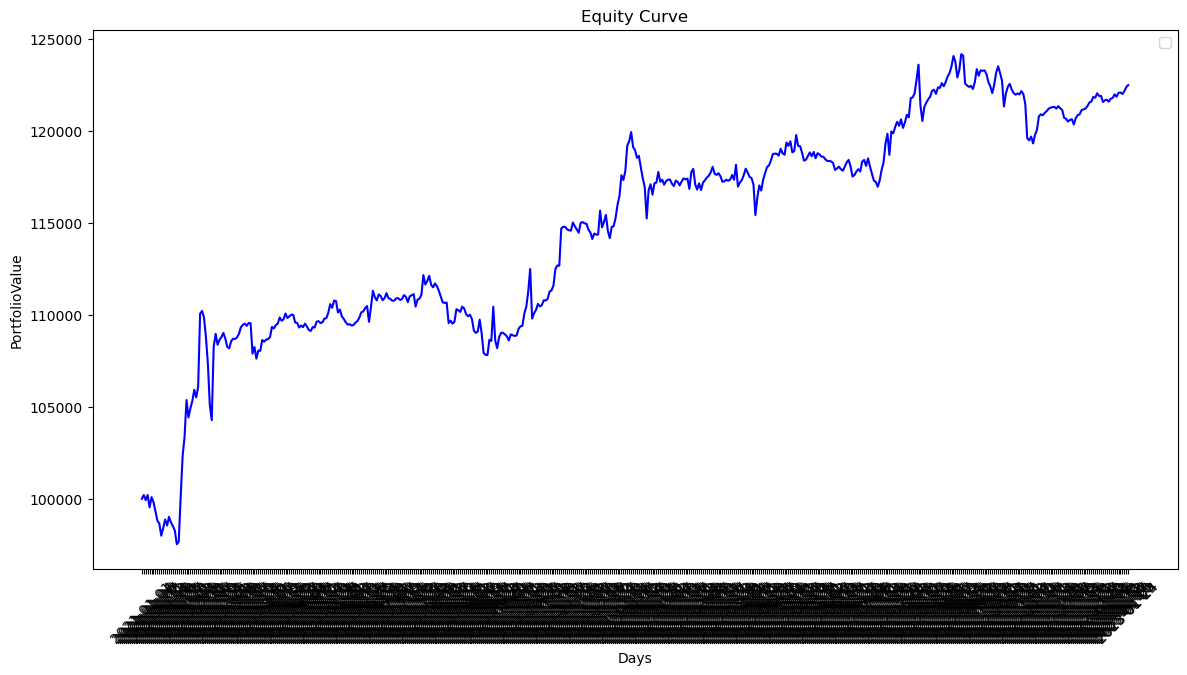

[Timestamp('2021-01-01 00:00:00'), Timestamp('2023-01-24 00:00:00')] [-100000.0, 122479.7835]
0.10328385723455458
max dd -5.384684693921892


,,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
Year,Change_%_Yearly,,,,,,,,,,,,
2021,15.272243,-2.330000,10.960000,-0.290000,1.410000,1.090000,0.010000,0.040000,-0.530000,-1.870000,1.920000,4.310000,0.230000
2022,5.658611,1.630000,0.670000,-0.500000,0.890000,0.190000,-0.860000,2.230000,1.680000,0.920000,-0.900000,-0.780000,0.420000
2023,0.562201,0.560000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [330]:
plvalue = []
pl = 0
result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

for idi, row in result.iterrows():
    pval = 0
    
    if result.loc[idi, 'D_marker'] == "F":

        result.loc[idi, 'pl_check'] = pl + initial_equity
        result.loc[idi+1:, 'pl_check'] = np.nan

        result.loc[idi , 'units_new'] = ((result.loc[idi ,'pl_check'])/result.loc[idi, 'margin'])
        result.loc[idi+1: , 'units_new'] = np.nan
       
        result.loc[idi, index + '_qty_final'] = result.loc[idi, index + "_qty"] * result.loc[idi, 'units_new']
        result.loc[idi+1:, index + '_qty_final'] = np.nan
        
        result.loc[idi, 'plvalue_' + index] = 0

        for i in stock_list:                                                                    
            result.loc[idi, i + '_qty_final'] = result.loc[idi, i + "_qty"] * result.loc[idi, 'units_new']
            result.loc[idi+1:, i + '_qty_final'] = np.nan
            result.loc[idi, 'plvalue_' + i] = 0
        
        result = result.ffill()

        
    elif result.loc[idi-1, 'D_marker'] == "L":
        

        result.loc[idi , 'units_new'] = ((result.loc[idi,'pl_check'])/result.loc[idi, 'margin'])
        result.loc[idi+1: , 'units_new'] = np.nan
       
        result.loc[idi, index + '_qty_final'] = result.loc[idi, index + "_qty"] * result.loc[idi, 'units_new']
        result.loc[idi+1:, index + '_qty_final'] = np.nan
        


        for i in stock_list:                                                                    
            result.loc[idi, i + '_qty_final'] = result.loc[idi, i + "_qty"] * result.loc[idi, 'units_new']
            result.loc[idi+1:, i + '_qty_final'] = np.nan
        
        result = result.ffill()
        
        
        if row["Trade_Type"] == "SILS":
            plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_Nextmonth_OPT_Close_CE"] - result.loc[idi, index + "_OPT_Close_CE"])
            plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_Nextmonth_OPT_Close_PE"] - result.loc[idi, index + "_OPT_Close_PE"])
            pval = plvalce + plvalpe

            result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

            for i in stock_list:
                plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_CE"] - result.loc[idi-1, i + "_Nextmonth_OPT_Close_CE"])
                plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_PE"] - result.loc[idi-1, i + "_Nextmonth_OPT_Close_PE"])
                pval += plvalce + plvalpe

                result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

        if row["Trade_Type"] == "LISS":
            plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] - result.loc[idi-1, index + "_Nextmonth_OPT_Close_CE"])
            plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_PE"] - result.loc[idi-1, index + "_Nextmonth_OPT_Close_PE"])
            pval = plvalce + plvalpe

            result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

            for i in stock_list:
                plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_Nextmonth_OPT_Close_CE"] - result.loc[idi, i + "_OPT_Close_CE"])
                plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_Nextmonth_OPT_Close_PE"] - result.loc[idi, i + "_OPT_Close_PE"])
                pval += plvalce + plvalpe

                result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 
        
        
    
    
    else:
        if row["Trade_Type"] == "SILS":
            plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] - result.loc[idi, index + "_OPT_Close_CE"])
            plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_PE"] - result.loc[idi, index + "_OPT_Close_PE"])
            pval = plvalce + plvalpe

            result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

            for i in stock_list:
                plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_CE"] - result.loc[idi-1, i + "_OPT_Close_CE"])
                plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_PE"] - result.loc[idi-1, i + "_OPT_Close_PE"])
                pval += plvalce + plvalpe

                result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

        if row["Trade_Type"] == "LISS":
            plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] - result.loc[idi-1, index + "_OPT_Close_CE"])
            plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_PE"] - result.loc[idi-1, index + "_OPT_Close_PE"])
            pval = plvalce + plvalpe

            result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

            for i in stock_list:
                plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_CE"] - result.loc[idi, i + "_OPT_Close_CE"])
                plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_PE"] - result.loc[idi, i + "_OPT_Close_PE"])
                pval += plvalce + plvalpe

                result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

        pl += pval

        
    plvalue.append(pval)

result["Daily_PL"] = plvalue

result.to_csv(output_path+"\pl_final4.csv")

result.loc[0,'Daily_PL'] = initial_equity
result["PortfolioValue"] = result["Daily_PL"].cumsum()
result.loc[0,'Daily_PL'] = 0

display(result)

result.to_csv(output_path+"/final4.1.csv")

fig = plt.figure(figsize=(14,7))
plt.title('Equity Curve')
plt.xlabel('Days')
plt.ylabel('PortfolioValue')
plt.plot((result["BANKNIFTY_Date_CE"]).astype('str'),result['PortfolioValue'], c = 'blue')

plt.xticks(rotation=45)

plt.legend()
plt.show()



### Calculate CAGR 

df = result.copy()
from pyxirr import xirr

firstValue = round(df.loc[0, 'PortfolioValue'],4)
lastValue = round(df.loc[df.index[-1], 'PortfolioValue'],4)

firstDate = (df.loc[0, 'BANKNIFTY_Date_CE'])
lastDate = (df.loc[df.index[-1], 'BANKNIFTY_Date_CE'])

dates = [firstDate, lastDate]
amounts = [-firstValue, lastValue]
print(dates,amounts)
xirr = xirr(dates, amounts)

print(xirr)
### Calculate Daily Drawdown

Roll_Max = round(df['PortfolioValue'].expanding().max(), 2)
Daily_Drawdown = (round(df['PortfolioValue'], 2)/Roll_Max) - 1.0


#Roll_Max[0:50], Daily_Drawdown[0:50]

df['Daily_Drawdown'] = Daily_Drawdown * 100

print("max dd", min(df['Daily_Drawdown']))

df.to_csv(output_path + '/DailyDrawdown.csv', index=False)

### Monthly PNL Percentage 

df['BANKNIFTY_Date_CE'] = pd.to_datetime(df['BANKNIFTY_Date_CE'], dayfirst=True)

df['Year'] = pd.DatetimeIndex(df['BANKNIFTY_Date_CE']).year
df['Month'] = pd.DatetimeIndex(df['BANKNIFTY_Date_CE']).month
df.to_csv(output_path + '/df.csv', index=False)

i = 0
dfg = df.groupby(['Year', 'Month'])
for name, group in dfg:
    #print(name)
    if i == 0: 
        firstValue = group['PortfolioValue'].iloc[0]
        i = 1
    else:
        firstValue = lastValue

    lastValue = group['PortfolioValue'].loc[group.index[-1]]
    change = lastValue/firstValue - 1
    df.loc[group.index, 'Change_%_Monthly'] = round(change * 100, 2)
    
i = 0
dfg = df.groupby(['Year'])
for name, group in dfg:
    #print(name)
    if i == 0: 
        firstValue = group['PortfolioValue'].iloc[0]
        i = 1
    else:
        firstValue = lastValue

    lastValue = group['PortfolioValue'].loc[group.index[-1]]
    change = lastValue/firstValue - 1
    df.loc[group.index, 'Change_%_Yearly'] = change * 100
    
df

df1 = df[['Year', 'Month', 'Change_%_Monthly', 'Change_%_Yearly']]
df1 = df1.drop_duplicates()
df1

pivotTable = df1.pivot_table(values ='Change_%_Monthly', index =['Year', 'Change_%_Yearly'],
                         columns =['Month'])
pivotTable.columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                      'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

pivotTable.index

def _color_red_or_green(val):
    color = '#EE0000' if val < 0 else '#00EE00'
    return 'background-color: %s' % color
pivotTable.style.applymap(_color_red_or_green)




In [ ]:
lol1 = pd.read_csv(output_path + "/final4.1.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
display(lol1)
lol1 = lol1.drop_duplicates()
display(lol1)

In [ ]:
display(curr_final_df)
display(next_final_df)

# Adjustments Starts Here

In [ ]:
result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)


result1 = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

result1["Date"] = result1["BANKNIFTY_Date_CE"]

final = pd.DataFrame()
final[index + '_Date_CE'] = result1["Date"]
for i in stock_list:
    print(i)
    path  = stfolder+ '/' + i + ".csv"
    df1 = pd.read_csv(path,parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close",f'Delta_{delta}_Strike','EQ_Close'], dayfirst = True)

    df_ce = df1[(df1["Strike"] == df1[f'Delta_{delta}_Strike']) & (df1["Option_Type"] == "CE")].add_suffix("_CE").add_prefix("Current_")
    df_pe = df1[(df1["Strike"] == df1[f'Delta_{delta}_Strike']) & (df1["Option_Type"] == "PE")].add_suffix("_PE").add_prefix("Current_")
    
    temp = df_ce.merge(df_pe, left_on='Current_Date_CE', right_on='Current_Date_PE').drop(columns = ["Current_Option_Type_PE","Current_Option_Type_CE"])
    temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Current_Date_CE').drop(columns = [i + "_Current_Date_CE"])
#final = final.T.drop_duplicates().T
result1 = result1.merge(final, how = "left", on = index+'_Date_CE')
result1.to_csv(output_path+"/final3.1.csv")
#display(result1)


# Trigger Adjustment

In [ ]:
# t = 100
# result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)



# print("trigger :", t)

# print("Generating trigger Signals.....")
# print("          ", datetime.datetime.now())
# result1 = pd.read_csv(output_path + "/final3.1.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

# for idi, row in result1.iterrows():
#     if row["D_marker"] == "F":

#         result1.loc[idi, index + 'total_premium'] = result1.loc[idi, index + '_OPT_Close_CE'] + result1.loc[idi, index + "_OPT_Close_PE"]

#         for i in stock_list:
#             result1.loc[idi, i + "D_marker_1"] = "F"
#             result1.loc[idi+1:, i + 'D_marker_1'] = "M"
#             result1.loc[idi, i + "D_marker_2"] = "F"
#             result1.loc[idi+1:, i + "D_marker_2"] = "M"


#             result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
#             result1.loc[idi, i + 'stop_trigger_CE'] = t*(result1.loc[idi, i + '_Current_Strike_CE'] + result1.loc[idi, i + 'total_premium'])/100
#             result1.loc[idi, i + 'stop_trigger_PE'] = t*(result1.loc[idi, i + '_Current_Strike_PE'] - result1.loc[idi, i + 'total_premium'])/100
#             result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
#             result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

#         result1 = result1.ffill()



#     else:
#         for i in stock_list:

#             if result1.loc[idi, "D_marker"] == "L":
#                 result1.loc[idi, i + "D_marker_1"] = "L"
#                 result1.loc[idi, i + "D_marker_2"] = "L"

#             else:

#                 if result1.loc[idi, i + 'stop_trigger_CE'] <= result1.loc[idi, i + '_Current_EQ_Close_CE']:
#                     result1.loc[idi, i + "D_marker_1"] = "L"
#                     result1.loc[idi, i + "D_marker_2"] = "F"

#                     result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
#                     result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
#                     result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
#                     result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
#                     result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan


#                 if result1.loc[idi, i + 'stop_trigger_PE'] >= result1.loc[idi, i + '_Current_EQ_Close_CE']:
#                     result1.loc[idi, i + "D_marker_1"] = "L"
#                     result1.loc[idi, i + "D_marker_2"] = "F"

#                     result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
#                     result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
#                     result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
#                     result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
#                     result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

#                 result1 = result1.ffill()


# #display(result1)      

# result1.to_csv(output_path + "/final3.2__" + str(t) + ".csv")



In [ ]:
trigger = [150]
result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)



for t in trigger:
    print("trigger :", t)
    
    print("Generating trigger Signals.....")
    print("          ", datetime.datetime.now())
    result1 = pd.read_csv(output_path + "/final3.1.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
    display(result1.info())
    for idi, row in result1.iterrows():
        if row["D_marker"] == "F":

            result1.loc[idi, index + 'total_premium'] = result1.loc[idi, index + '_OPT_Close_CE'] + result1.loc[idi, index + "_OPT_Close_PE"]

            for i in stock_list:
                result1.loc[idi, i + "D_marker_1"] = "F"
                result1.loc[idi+1:, i + 'D_marker_1'] = "M"
                result1.loc[idi, i + "D_marker_2"] = "F"
                result1.loc[idi+1:, i + "D_marker_2"] = "M"
                

                result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
                result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
                result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

            result1 = result1.ffill()



        else:
            for i in stock_list:

                if result1.loc[idi, "D_marker"] == "L":
                    result1.loc[idi, i + "D_marker_1"] = "L"
                    result1.loc[idi, i + "D_marker_2"] = "L"

                else:

                    if result1.loc[idi, i + 'stop_trigger_CE'] <= result1.loc[idi, i + '_Current_EQ_Close_CE']:
                        result1.loc[idi, i + "D_marker_1"] = "L"
                        result1.loc[idi, i + "D_marker_2"] = "F"

                        result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                        result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                        result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan


                    if result1.loc[idi, i + 'stop_trigger_PE'] >= result1.loc[idi, i + '_Current_EQ_Close_CE']:
                        result1.loc[idi, i + "D_marker_1"] = "L"
                        result1.loc[idi, i + "D_marker_2"] = "F"

                        result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                        result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                        result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

                    result1 = result1.ffill()


    #display(result1)      

    result1.to_csv(output_path + "/final3.2__" + str(t) + ".csv")

    #######################################################################################################################
    
    print("Generating TradeList.....")
    print("          ", datetime.datetime.now())
    
    trades = []
    for j in stock_list:
        df = result1[(result1[j + "D_marker_1"] == "F") | (result1[j + "D_marker_1"] == "L")].reset_index()
        #display(df)

        for i in df.index[:-1]:
            if df[j + "D_marker_2"][i] == "F":
                strikes = {}
                strikes[j] = df[j+"_Current_Strike_CE"][i]
                trades.append( 
                                { 
                                  "symbol" : j,
                                  j + "_entry_date": df[index + "_Date_CE"][i],
                                  j + "_exit_date" : df[index + "_Date_CE"][i+1],
                                  "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                                  "new_month_date" : df[index+"_curr_exp_date_CE"][i+1],
                                  "strike" : strikes,
                                  "marker_1" : df[j + "D_marker_1"][i],
                                  "marker_2" : df[j + "D_marker_2"][i],

                                }
                              )

    #######################################################################################################################


    df_dum = pd.DataFrame()

    df_dum['Date'] = result1['BANKNIFTY_Date_CE']

    for j in stock_list:
        print(j)
        path = stfolder + '/' + j + ".csv"
        for i in trades:
            symbol = i["symbol"]
            if j == symbol:
                #print("####################",j)
                date1 = i[j + "_entry_date"]
                date2 = i[j + "_exit_date"]
                expiry = i["expiry_date"]
                new_month_date = i["new_month_date"]
                marker_1 = i["marker_1"]
                marker_2 = i["marker_2"]
#                 print(date1)
#                 print(date2)
#                 print(i["strike"][j])

                if ((marker_1 == "F") & (marker_2 == "F")):       #new trade data from same row
                    df_dict = {}

                    df = pd.read_csv(path,parse_dates = ["Date"], dayfirst = True)

                    df = df[(df["Date"] >= date1) & (df["Date"] <= date2) & (df["Strike"] == i["strike"][j])]
                    df = pd.merge(df_dum, df, on = 'Date', how = 'left')
                    df_dict[j] = df
                    i["dataframes"] = df_dict

                elif (marker_1 == "L") & (marker_2 == "F"):     #new trade data from next row

                    df_dict = {}

                    df = pd.read_csv(path,parse_dates = ["Date"], dayfirst = True)

                    df = df[(df["Date"] > date1) & (df["Date"] <= date2) & (df["Strike"] == i["strike"][j])]
                    df = pd.merge(df_dum, df, on = 'Date', how = 'left')
                    df_dict[j] = df
                    i["dataframes"] = df_dict




    #######################################################################################################################



    result1 = pd.DataFrame()
    result1[index + "_Date_CE"] = result[index + "_Date_CE"]
    result1.to_csv(output_path + "/final3.3check.csv")
    print("CHECK final3.3check")
    for j in stock_list:
        print("j", j)
        final = pd.DataFrame()

        for trade_dict in trades:
            df_dict = trade_dict["dataframes"]

            for i in df_dict:

                    if (i != j):
                        continue

                    df1 = df_dict[i][["Date","Ticker","OPT_Close","Strike","Option_Type","IV","EQ_Close"]]
                    df_ce = df1[(df1["Option_Type"] == "CE")].add_suffix("_CE")
                    df_pe = df1[(df1["Option_Type"] == "PE")].add_suffix("_PE")
                    
                    temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
                    temp = temp.T.drop_duplicates().T
                    temp['Date_CE'] = pd.to_datetime(temp['Date_CE'], dayfirst = True)
                    temp = temp.add_prefix(i +"_new_")
                    final = final.append(temp)
                    

        result1 = result1.merge(final,left_on=index + '_Date_CE' , right_on= j + '_new_Date_CE', how = 'left')

    result1 = result1.T.drop_duplicates().T    
    result1.to_csv(output_path + "/final3.3__" + str(t) + ".csv")
    #display(result1)    



    #######################################################################################################################



    result1 = pd.read_csv(output_path + "/final3.2__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
    result2 = pd.read_csv(output_path + "/final3.3__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)


    result = result1.merge(result2,how='left',on=index+'_Date_CE')

    result.to_csv(output_path + "/final4.csv")
    #display(result)




    #######################################################################################################################
    print("Calculating PnL.....")
    print("          ", datetime.datetime.now())

    result = pd.read_csv(output_path + "/final4.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

    u = result.select_dtypes(exclude=['datetime'])
    result[u.columns] = u.fillna(0)


    plvalue = []
    pl = 0
    transaction_cost = 0

    for idi, row in result.iterrows():
        pval = 0
        if row["D_marker"] == "F":
                        
            
            result.loc[idi, 'pl_check'] = pl + initial_equity
            result.loc[idi+1:, 'pl_check'] = np.nan

            result.loc[idi , 'units_new'] = ((result.loc[idi ,'pl_check'])/result.loc[idi, 'margin'])
            result.loc[idi+1: , 'units_new'] = np.nan

            result.loc[idi, index + '_qty_final'] = result.loc[idi, index + "_qty"] * result.loc[idi, 'units_new']
            result.loc[idi+1:, index + '_qty_final'] = np.nan

            result.loc[idi, 'plvalue_' + index] = 0
            
            contract_value = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] + result.loc[idi, index + "_OPT_Close_PE"])
            
            
            for i in stock_list:                                                                    
                result.loc[idi, i + '_qty_final'] = result.loc[idi, i + "_qty"] * result.loc[idi, 'units_new']
                result.loc[idi+1:, i + '_qty_final'] = np.nan
                result.loc[idi, 'plvalue_' + i] = 0
                contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_CE"] + result.loc[idi, i + "_OPT_Close_PE"])

            result.loc[idi, 'transaction_cost'] = transaction_cost
            result = result.ffill()
        

        else:

                if row["Trade_Type"] == "SILS":
                    plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] - result.loc[idi, index + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_PE"] - result.loc[idi, index + "_OPT_Close_PE"])
                    pval = plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

                    for i in stock_list:

                        if result.loc[idi-1,i+"D_marker_2"] == "F":

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] - result.loc[idi-1, i + "_Current_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_PE"] - result.loc[idi-1, i + "_Current_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

                        else:

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] - result.loc[idi-1, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_PE"] - result.loc[idi-1, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe
                            
                        if ((result.loc[idi, i+"D_marker_1"] == "L") & (result.loc[idi, i+"D_marker_2"] == "F")):
                            
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] + result.loc[idi, i + "_new_OPT_Close_PE"])
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_Current_OPT_Close_CE"] + result.loc[idi, i + "_Current_OPT_Close_PE"])
                            
                if row["Trade_Type"] == "LISS":
                    plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] - result.loc[idi-1, index + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_PE"] - result.loc[idi-1, index + "_OPT_Close_PE"])
                    pval = plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

                    for i in stock_list:
                        if result.loc[idi-1,i+"D_marker_2"] == "F":
                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_Current_OPT_Close_CE"] - result.loc[idi, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_Current_OPT_Close_PE"] - result.loc[idi, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

                        else:

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_new_OPT_Close_CE"] - result.loc[idi, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_new_OPT_Close_PE"] - result.loc[idi, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 
                        
                        if ((result.loc[idi, i+"D_marker_1"] == "L") & (result.loc[idi, i+"D_marker_2"] == "F")):
                            
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] + result.loc[idi, i + "_new_OPT_Close_PE"])
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_Current_OPT_Close_CE"] + result.loc[idi, i + "_Current_OPT_Close_PE"])



                pl += pval

        
        if row['D_marker'] == "L":
            
            contract_value += result.loc[idi-1, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] + result.loc[idi-1, index + "_OPT_Close_PE"])
            
            for i in stock_list:                                                                    
                contract_value += result.loc[idi-1, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_CE"] + result.loc[idi-1, i + "_OPT_Close_PE"])
            
            transaction_cost = contract_value*0.005
            pl = pl - transaction_cost
            result.loc[idi, 'transaction_cost'] = transaction_cost
        
        plvalue.append(pval)

    result["Daily_PL"] = plvalue

    #result.to_csv(output_path+"\pl_final4.csv")


    result.loc[0,'Daily_PL'] = initial_equity
    result["PortfolioValue"] = (result["Daily_PL"] - result["transaction_cost"]).cumsum()
    result.loc[0,'Daily_PL'] = 0

    #display(result)
    result.to_csv(output_path+"/final4.1__" + str(t) + ".csv")
    
    #######################################################################################################################



    finallist = pd.DataFrame()
    tradelist = result[ (result["D_marker"] == "F") | (result["D_marker"] == "L") ]

    if list(tradelist.iloc[[-1]]["D_marker"])[0] == "F":
        tradelist.drop(tradelist.tail(1).index,inplace=True)
    else:
        tradelist = tradelist

    tr1 = tradelist[tradelist["D_marker"]=="F"].reset_index().drop(columns = ["index"])
    tr2 = tradelist[tradelist["D_marker"]=="L"].reset_index().drop(columns = ["index"])

    #print(tr1.shape[0])
    if tr1.shape[0] == tr2.shape[0]:
        for idx in tr1.index:
            mdict = {}
            mdict["Entry_Date"] = tr1[index+ "_Date_CE"][idx]
            mdict["Exit_Date"] = tr2[index+ "_Date_CE"][idx]
            mdict["Trade_Type"] = tr1["Trade_Type"][idx]
            for i in symbols:
                for j in ["CE","PE"]:
                    mdict[i + "_Entry_Price_" + j] = tr1[i + "_OPT_Close_" + j][idx] 
                    mdict[i + "_Exit_Price_" + j] = tr2[i + "_OPT_Close_" + j][idx]
                    mdict[i + "_Qty_" + j] = tr1[i + "_qty_final"][idx]
            temp = pd.DataFrame([mdict])
            #display(temp)
            finallist = finallist.append(temp)
    else:
        print("Error, Tradelist not proper")

    finallist.reset_index().drop(columns = ["index"])





    #######################################################################################################################




    #tradelist =  pd.concat([finallist, finallist_exp], axis=1)

    tradelist = finallist

    #display(tradelist)

    #tradelist.to_csv(output_path+"/trdlist.csv")

    pl_tradelist = tradelist.copy()
    plvalue = []
    pval = 0
    for idi, row in pl_tradelist.iterrows():

        if row["Trade_Type"] == "SILS":
            pvalce = row[index + "_Qty_CE"]*(row[index + "_Entry_Price_CE"] - row[index + "_Exit_Price_CE"])
            pvalpe = row[index + "_Qty_PE"]*(row[index + "_Entry_Price_PE"] - row[index + "_Exit_Price_PE"])
            pval = pvalce + pvalpe

            for i in stock_list:
                pvalce = row[i + "_Qty_CE"]*(row[i + "_Exit_Price_CE"] - row[i + "_Entry_Price_CE"])
                pvalpe = row[i + "_Qty_PE"]*(row[i + "_Exit_Price_PE"] - row[i + "_Entry_Price_PE"])
                pval += pvalce + pvalpe    

        if row["Trade_Type"] == "LISS":
            pvalce = row[index + "_Qty_CE"]*(row[index + "_Exit_Price_CE"] - row[index + "_Entry_Price_CE"])
            pvalpe = row[index + "_Qty_PE"]*(row[index + "_Exit_Price_PE"] - row[index + "_Entry_Price_PE"])
            pval = pvalce + pvalpe

            for i in stock_list:
                pvalce = row[i + "_Qty_CE"]*(row[i + "_Entry_Price_CE"] - row[i + "_Exit_Price_CE"])
                pvalpe = row[i + "_Qty_PE"]*(row[i + "_Entry_Price_PE"] - row[i + "_Exit_Price_PE"])
                pval += pvalce + pvalpe    

        plvalue.append(pval)

    pl_tradelist['pl'] = plvalue
    pl_tradelist.to_csv(output_path+"\pl_trdlist__" + str(t) + ".csv")



    #######################################################################################################################




    ### Calculate CAGR 
    result = pd.read_csv(output_path+"/final4.1__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
    df = result.copy()
    from pyxirr import xirr

    firstValue = int(df.loc[0, 'PortfolioValue'])
    lastValue = int(df.loc[df.index[-1], 'PortfolioValue'])

    firstDate = (df.loc[0, 'BANKNIFTY_Date_CE'])
    lastDate = (df.loc[df.index[-1], 'BANKNIFTY_Date_CE'])

    dates = [firstDate, lastDate]
    amounts = [-firstValue, lastValue]
    
    
    xirr = xirr(dates, amounts)

    print("xirr : ", xirr*100)
    ### Calculate Daily Drawdown

    Roll_Max = round(df['PortfolioValue'].expanding().max(), 2)
    Daily_Drawdown = (round(df['PortfolioValue'], 2)/Roll_Max) - 1.0



    df['Daily_Drawdown'] = Daily_Drawdown * 100

    print("max dd : ", min(df['Daily_Drawdown']))

    df.to_csv(output_path + '/DailyDrawdown.csv', index=False)

    ### Monthly PNL Percentage 

    df['BANKNIFTY_curr_exp_date_CE'] = pd.to_datetime(df['BANKNIFTY_curr_exp_date_CE'], dayfirst=True)

    df['Year'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).year
    df['Month'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).month
    df.to_csv(output_path + '/df.csv', index=False)

    i = 0
    dfg = df.groupby(['Year', 'Month'])
    for name, group in dfg:
        #print(name)
        if i == 0: 
            firstValue = group['PortfolioValue'].iloc[0]
            i = 1
        else:
            firstValue = lastValue

        lastValue = group['PortfolioValue'].loc[group.index[-1]]
        change = lastValue/firstValue - 1
        df.loc[group.index, 'Change_%_Monthly'] = round(change * 100, 2)

    i = 0
    dfg = df.groupby(['Year'])
    for name, group in dfg:
        #print(name)
        if i == 0: 
            firstValue = group['PortfolioValue'].iloc[0]
            i = 1
        else:
            firstValue = lastValue

        lastValue = group['PortfolioValue'].loc[group.index[-1]]
        change = lastValue/firstValue - 1
        df.loc[group.index, 'Change_%_Yearly'] = change * 100

    df

    df1 = df[['Year', 'Month', 'Change_%_Monthly', 'Change_%_Yearly']]
    df1 = df1.drop_duplicates()
    df1

    pivotTable = df1.pivot_table(values ='Change_%_Monthly', index =['Year', 'Change_%_Yearly'],
                             columns =['Month'])
    pivotTable.columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                          'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

    pivotTable.index

    def _color_red_or_green(val):
        color = '#EE0000' if val < 0 else '#00EE00'
        return 'background-color: %s' % color
    pivotTable.style.applymap(_color_red_or_green)








In [ ]:
    def _color_red_or_green(val):
        color = '#EE0000' if val < 0 else '#00EE00'
        return 'background-color: %s' % color
    pivotTable.style.applymap(_color_red_or_green)
